### Parts of this assignment will be **automatically graded**. Please take note of the following:
- Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).
- You can add additional cells, but it is not recommended to (re)move cells. Cells required for autograding cannot be moved and cells containing tests cannot be edited.
- You are allowed to use a service such as [Google Colaboratory](https://colab.research.google.com/) to work together. However, you **cannot** hand in the notebook that was hosted on Google Colaboratory, but you need to copy your answers into the original notebook and verify that it runs succesfully offline. This is because Google Colaboratory destroys the metadata required for grading.
- Name your notebook **exactly** `{TA_name}_{student1_id}_{student2_id}_lab{i}.ipynb`, for example `wouter_12345_67890_lab1.ipynb` (or tim|elise|david|qi, depending on your TA), **otherwise your submission will be skipped by our regex and you will get 0 points** (but no penalty as we cannot parse your student ids ;)).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your names below:

In [1]:
NAMES = "Philipp Lintl, Bogdan Floris"

---

In [2]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import sys

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm as _tqdm

import random
import time
from collections import defaultdict

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

EPS = float(np.finfo(np.float32).eps)

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

## 1. Temporal Difference (TD) learning (8 points)
Mention one advantage and one disadvantage of Monte Carlo methods. Mention an example where you would prefer to use TD learning.

One advantage of Monte Carlo methods is that it does not require a full knowledge of the environment (MDP), but the disadvatange is that it does not learn until the episode ends (and thus only works for episodic tasks). TD learning is prefered when the task is not episodic (we do not need to store sample trajectories) and the model is unknown.

For the TD algorithms, we will skip the prediction algorithm and go straight for the control setting where we optimize the policy that we are using. In other words: implement SARSA. To keep it dynamic, we will use the windy gridworld environment (Example 6.5).

In [3]:
from windy_gridworld import WindyGridworldEnv
env = WindyGridworldEnv()

In [8]:
import itertools

def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    """
    def policy_fn(observation):
        return int(np.random.rand() * nA) if np.random.rand() < epsilon else np.argmax(Q[observation])
    return policy_fn



  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 3512.45it/s]

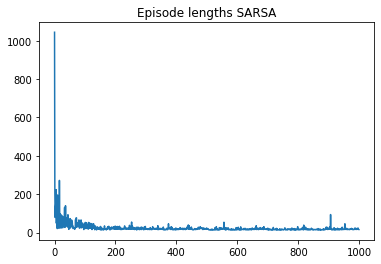

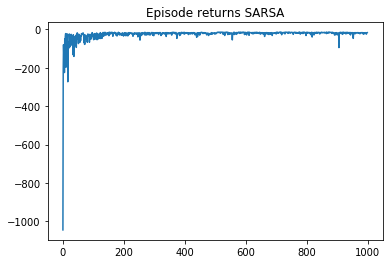

In [44]:
def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1, Q=None):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Probability to sample a random action. Float between 0 and 1.
        Q: hot-start the algorithm with a Q value function (optional)
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is a list of tuples giving the episode lengths and rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    if Q is None:
        Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = []
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)

    for i_episode in tqdm(range(num_episodes)):
        episode_reward = 0
        # initialize state
        state = env.reset()
        # choose action from state based on the policy
        action = policy(state)
        # loop for each step in the episode
        for step in itertools.count():
            # take action and observe the next state, reward, and if we are done
            next_state, reward, done, _ = env.step(action)
            # choose an action from next_state using the policy
            next_action = policy(next_state)
            # update the total episode reward
            episode_reward += reward
            # sarsa Q update
            Q[state][action] += alpha * (reward + discount_factor * Q[next_state][next_action] - Q[state][action])
            # check for finished episode
            if done:
                break
            # otherwise update state and action
            state = next_state
            action = next_action
        
        stats.append((step, episode_reward))
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)

Q_sarsa, (episode_lengths_sarsa, episode_returns_sarsa) = sarsa(env, 1000)

# We will help you with plotting this time
plt.plot(episode_lengths_sarsa)
plt.title('Episode lengths SARSA')
plt.show()
plt.plot(episode_returns_sarsa)
plt.title('Episode returns SARSA')
plt.show()

We learn the optimal (non-exploring) policy while using another policy to do exploration, which is where we arrive at _off-policy_ learning. In the simplest variant, we learn our own value by bootstrapping based on the action value corresponding to the best action we could take, while the exploration policy actual follows the $\epsilon$-greedy strategy. This is known as Q-learning.



  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 3681.92it/s]

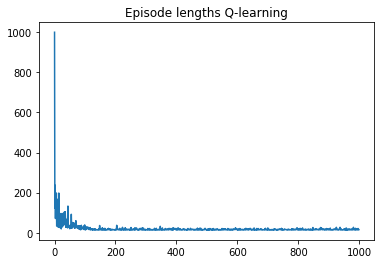

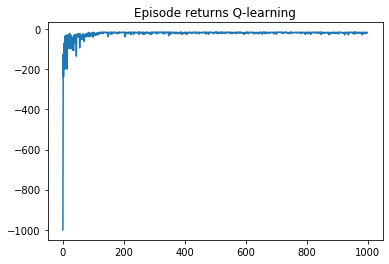

In [45]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1, Q=None):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Probability to sample a random action. Float between 0 and 1.
        Q: hot-start the algorithm with a Q value function (optional)
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is a list of tuples giving the episode lengths and rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    if Q is None:
        Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = []
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    

    for i_episode in tqdm(range(num_episodes)):
        episode_reward = 0
        # initialize the state
        state = env.reset()
        # loop for each step in the episode
        for t in itertools.count():
            # choose action from state based on the policy
            action = policy(state)
            # take a step in the environment
            next_state, reward, done, _ = env.step(action)
            # update statistics
            episode_reward += reward
            # update Q
            best_next_action = np.argmax(Q[next_state])
            Q[state][action] += alpha * (reward + discount_factor *
                Q[next_state][best_next_action] - Q[state][action])
            # check for finished episode
            if done:
                break
            # otherwise update state
            state = next_state

        stats.append((t, episode_reward))
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)

Q_q_learning, (episode_lengths_q_learning, episode_returns_q_learning) = q_learning(env, 1000)

# We will help you with plotting this time
plt.plot(episode_lengths_q_learning)
plt.title('Episode lengths Q-learning')
plt.show()
plt.plot(episode_returns_q_learning)
plt.title('Episode returns Q-learning')
plt.show()

Now compare the episode returns while learning for Q-learning and Sarsa (maybe run some more iterations?), by plotting the returns for both algorithms in a single plot, like in the book, Example 6.6. In order to be able to compare them, you may want to zoom in on the y-axis and smooth the returns (e.g. plotting the $n$ episode average instead).

In [22]:
def get_episode_rewards_average(algo, n=100):
    episode_rewards = np.zeros(1000)
    for i in range(n):
        _, (_, episode_returns) = algo(env, 1000)
        episode_rewards += episode_returns
    return episode_rewards / n

# Compute episode rewards for SARSA
episode_rewards_sarsa = get_episode_rewards_average(sarsa)
# COmpute episode rewards for Q-Learning
episode_rewards_q_learning = get_episode_rewards_average(q_learning)
    

100%|██████████| 1000/1000 [00:00<00:00, 4275.99it/s]


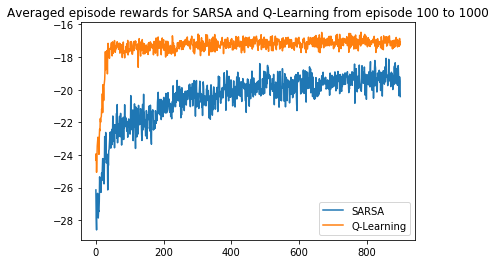

In [36]:
plt.plot(episode_rewards_sarsa[100:], label="SARSA")
plt.plot(episode_rewards_q_learning[100:], label="Q-Learning")
plt.title("Averaged episode rewards for SARSA and Q-Learning from episode 100 to 1000")
plt.legend()
plt.show()

Which algorithm achieves higher return during learning? How does this compare to Example 6.6 from the book? Try to explain your observations.

For the Windy Gridworld environment, Q-Learning achieves the higher returns during learning, which is opposed to the Cliff Walking environment. Since there is no risk in running of a cliff in this example, Q-Learning can learn the optiomal policy and progress through it even with an $\epsilon$-greedy policy.

After we have learned the policy, we do not care about exploration any more and we may switch to a deterministic (greedy) policy instead. If we evaluate this for both Sarsa and Q-learning (actually, for Q-learning the learned policy is already deterministic), which policy would you expect to perform better? Why?

Since Q-Learning seems to have learned the better policy, it should perform slightly better than SARSA even in a deterministic setting.

Please run the experiments to test your hypothesis (print or plot your results). How many runs do you need to evaluate the policy? Note: without learning, the order of the episodes is not relevant so a normal `plt.plot` may not be the most appropriate choice.

Since the policies are deterministic, we only need one run to determine the rewards for both algorithms.

In [51]:
# Get the deterministic policies
policy_sarsa = make_epsilon_greedy_policy(Q_sarsa, 0.0, env.action_space.n)
policy_q_learning= make_epsilon_greedy_policy(Q_q_learning, 0.0, env.action_space.n)

def get_rewards(env, policy, num_episodes=1):
    rewards = []
    for _ in tqdm(range(num_episodes)):
        episode_reward = 0
        # initialize the state
        state = env.reset()
        # loop for each step in the episode
        for t in itertools.count():
            # choose action from state based on the policy
            action = policy(state)
            # take a step in the environment
            next_state, reward, done, _ = env.step(action)
            # update statistics
            episode_reward += reward
            # check for finished episode
            if done:
                break
            # otherwise update state
            state = next_state
        rewards.append(episode_reward)
    
    return rewards

determ_rewards_sarsa = get_rewards(env, policy_sarsa)
determ_rewards_q_learning = get_rewards(env, policy_q_learning)



  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 622.67it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 666.29it/s]

In [53]:
print("Deterministic rewards SARSA: {}".format(np.mean(determ_rewards_sarsa)))
print("Deterministic rewards Q-Learning: {}".format(np.mean(determ_rewards_q_learning)))

Deterministic rewards SARSA: -16.0
Deterministic rewards Q-Learning: -15.0


---
## 2. Deep Q-Network (DQN) (10 points)

In [54]:
import gym
env = gym.envs.make("CartPole-v0")

/Users/bogdanfloris/miniconda3/envs/rl2019/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [55]:
# env is a TimeLimit wrapper around an env, so use env.env to look into the env (but otherwise you can forget about this)
??env.env

In [56]:
import time
# The nice thing about the CARTPOLE is that it has very nice rendering functionality (if you are on a local environment). Let's have a look at an episode
obs = env.reset()
env.render()
done = False
while not done:
    obs, reward, done, _ = env.step(env.action_space.sample())
    env.render()
    time.sleep(0.05)
env.close()  # Close the environment or you will have a lot of render screens soon

Remember from the previous lab, that in order to optimize a policy we need to estimate the Q-values (e.g. estimate the *action* values). In the CartPole problem, our state is current position of the cart, the current velocity of the cart, the current (angular) position of the pole and the (angular) speed of the pole. As these are continuous variables, we have an infinite number of states (ignoring the fact that a digital computer can only represent finitely many states in finite memory).

Can you think of a way in which we can still use a tabular approach? Why would this work and can you think of an example problem where this would not work?

One way in which we can still use a tabular approach is to aggregate the values into bins. All the values that make up a state in CartPole have a minimum and a maximum. This approach fails for problems where we cannot determine a minimum or a maximum value and thus we cannot determine the ammount of bins to use for aggregation.

### 2.1 Implement Q-Network

We will not use the tabular approach but approximate the Q-value function by a general approximator function. We will skip the linear case and directly use a two layer Neural Network. We use [PyTorch](https://pytorch.org/) to implement the network, as this will allow us to train it easily later. We can implement a model using `torch.nn.Sequential`, but with PyTorch it is actually very easy to implement the model (e.g. the forward pass) from scratch. Now implement the `QNetwork.forward` function that uses one hidden layer with ReLU activation (no output activation).

In [59]:
class QNetwork(nn.Module):
    
    def __init__(self, num_hidden=128):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(4, num_hidden)
        self.l2 = nn.Linear(num_hidden, 2)

    def forward(self, x):
        return self.l2(torch.relu(self.l1(x)))

In [60]:
# Let's instantiate and test if it works
num_hidden = 128
torch.manual_seed(1234)
model = QNetwork(num_hidden)

torch.manual_seed(1234)
test_model = nn.Sequential(
    nn.Linear(4, num_hidden), 
    nn.ReLU(), 
    nn.Linear(num_hidden, 2)
)

x = torch.rand(10, 4)

# If you do not need backpropagation, wrap the computation in the torch.no_grad() context
# This saves time and memory, and PyTorch complaints when converting to numpy
with torch.no_grad():
    assert np.allclose(model(x).numpy(), test_model(x).numpy())

### 2.2 Experience Replay

What could be a problem with doing gradient updates on a sequence of state, action pairs $((s_t, a_t), (s_{t+1}, a_{t+1}) ...)$ observed while interacting with the environment? How will using *experience replay* help to overcome this (potential problem)?

Doing gradient updates on a sequence of state, action pairs clearly violates the independence assumption of the data. Since the states come in a sequence, they are very much dependent on each other. Experience replay helps overcome this problem by randomly sampling from a big pool of state, action pairs. The data is still dependent but clearly not as much.

Now implement the `push` function that adds a transition to the replay buffer, and the sample function that returns a batch of samples. It should keep at most the maximum number of transitions. Also implement the `sample` function that samples a (random!) batch of data, for use during training (hint: you can use the function `random.sample`).

In [61]:
import random

In [62]:
class ReplayMemory:
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition):
        if len(self.memory) == self.capacity:
            self.memory.pop(0)
        self.memory.append(transition)

    def sample(self, batch_size):
        if len(self.memory) < batch_size:
            raise ValueError('Not enough memory to sample batch.')
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [63]:
capacity = 10
memory = ReplayMemory(capacity)

# Sample a transition
s = env.reset()
a = env.action_space.sample()
s_next, r, done, _ = env.step(a)

# Push a transition
memory.push((s, a, r, s_next, done))

# Sample a batch size of 1
print(memory.sample(1))


[(array([-0.01641128, -0.01327852, -0.00861558, -0.04991406]), 0, 1.0, array([-0.01667685, -0.20827588, -0.00961386,  0.24003818]), False)]


### 2.3 $\epsilon$psilon greedy policy

In order to learn a good policy, we need to explore quite a bit initially. As we start to learn a good policy, we want to decrease the exploration. As the amount of exploration using an $\epsilon$-greedy policy is controlled by $\epsilon$, we can define an 'exploration scheme' by writing $\epsilon$ as a function of time. There are many possible schemes, but we will use a simple one: we will start with only exploring (so taking random actions) at iteration 0, and then in 1000 iterations linearly anneal $\epsilon$ such that after 1000 iterations we take random (exploration) actions with 5\% probability (forever, as you never know if the environment will change).

In [66]:
epsilons = np.linspace(1.0, 0.05, 1000)

def get_epsilon(it):
    if it >= 1000:
        return 0.05
    else:
        return epsilons[it]

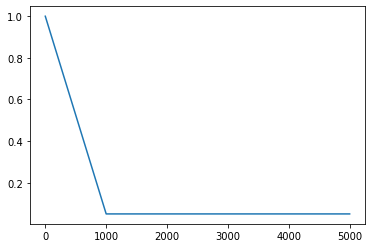

In [67]:
# So what's an easy way to check?
plt.plot([get_epsilon(it) for it in range(5000)])


Now write a function that takes a state and uses the Q-network to select an ($\epsilon$-greedy) action. It should return a random action with probability epsilon (which we will pass later). Note, you do not need to backpropagate through the model computations, so use `with torch.no_grad():` (see above for example). Unlike numpy, PyTorch has no argmax function, but Google is your friend... Note that to convert a PyTorch tensor with only 1 element (0 dimensional) to a simple python scalar (int or float), you can use the '.item()' function.

In [94]:
def select_action(model, state, epsilon):
    if np.random.rand() < epsilon:
        return int(np.random.rand() * 2)
    else:
        with torch.no_grad():
            output = model(torch.Tensor(state))
            return torch.argmax(output).item()
        

In [95]:
s = env.reset()
a = select_action(model, s, 0.05)
assert not torch.is_tensor(a)
print (a)


1


### 2.4 Training function

Now we will implement the function 'train' that samples a batch from the memory and performs a gradient step using some convenient PyTorch functionality. However, you still need to compute the Q-values for the (state, action) pairs in the experience, as well as their target (e.g. the value they should move towards). What is the target for a Q-learning update? What should be the target if `next_state` is terminal (e.g. `done`)?

For computing the Q-values for the actions, note that the model returns all action values where you are only interested in a single action value. Because of the batch dimension, you can't use simple indexing, but you may want to have a look at [torch.gather](https://pytorch.org/docs/stable/torch.html?highlight=gather#torch.gather) or use [advanced indexing](https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.indexing.html) (numpy tutorial but works mostly the same in PyTorch). Note, you should NOT modify the function train. You can view the size of a tensor `x` with `x.size()` (similar to `x.shape` in numpy).

In [122]:
def compute_q_val(model, state, action):
    q_val = model(state)
    return q_val[np.arange(action.size()[0]), action]
    
def compute_target(model, reward, next_state, done, discount_factor):
    # done is a boolean (vector) that indicates if next_state is terminal (episode is done)
    q_val_next = model(next_state)
    targets = reward + discount_factor * (1 - done).float() * torch.max(q_val_next, dim=1)[0]
    return targets

def train(model, memory, optimizer, batch_size, discount_factor):
    # DO NOT MODIFY THIS FUNCTION
    
    # don't learn without some decent experience
    if len(memory) < batch_size:
        return None

    # random transition batch is taken from experience replay memory
    transitions = memory.sample(batch_size)
    
    # transition is a list of 4-tuples, instead we want 4 vectors (as torch.Tensor's)
    state, action, reward, next_state, done = zip(*transitions)
    
    # convert to PyTorch and define types
    state = torch.tensor(state, dtype=torch.float)
    action = torch.tensor(action, dtype=torch.int64)  # Need 64 bit to use them as index
    next_state = torch.tensor(next_state, dtype=torch.float)
    reward = torch.tensor(reward, dtype=torch.float)
    done = torch.tensor(done, dtype=torch.uint8)  # Boolean
    
    # compute the q value
    q_val = compute_q_val(model, state, action)
    
    with torch.no_grad():  # Don't compute gradient info for the target (semi-gradient)
        target = compute_target(model, reward, next_state, done, discount_factor)
    
    # loss is measured from error between current and newly expected Q values
    loss = F.smooth_l1_loss(q_val, target)

    # backpropagation of loss to Neural Network (PyTorch magic)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()  # Returns a Python scalar, and releases history (similar to .detach())

In [123]:
# You may want to test your functions individually, but after you do so lets see if the method train works.
batch_size = 64
discount_factor = 0.8
learn_rate = 1e-3
# Simple gradient descent may take long, so we will use Adam
optimizer = optim.Adam(model.parameters(), learn_rate)

# We need a larger memory, fill with dummy data
transition = memory.sample(1)[0]
memory = ReplayMemory(10 * batch_size)
for i in range(batch_size):
    memory.push(transition)

# Now let's see if it works
loss = train(model, memory, optimizer, batch_size, discount_factor)

print (loss)


0.5715031027793884


### 2.5 Put it all together

Now that you have implemented the training step, you should be able to put everything together. Implement the function `run_episodes` that runs a number of episodes of DQN training. It should return the durations (e.g. number of steps) of each episode. Note: we pass the train function as an argument such that we can swap it for a different training step later.

In [124]:
def run_episodes(train, model, memory, env, num_episodes, batch_size, discount_factor, learn_rate):
    
    optimizer = optim.Adam(model.parameters(), learn_rate)
    
    global_steps = 0  # Count the steps (do not reset at episode start, to compute epsilon)
    episode_durations = []  #
    for i in range(num_episodes):
        # Get the initial state
        state = env.reset()
        loss = None
        
        for t in itertools.count():
            # Get the epsilon
            epsilon = get_epsilon(global_steps)
            
            # Get an action and take a step
            action = select_action(model, state, epsilon)
            next_state, reward, done, _ = env.step(action)
            
            # Save to memory
            memory.push((state, action, reward, next_state, done))
            
            # Train
            loss = train(model, memory, optimizer, batch_size, discount_factor)

            # Print the step
            print("Step {} ({}); Episode {}/{}; Loss: {}".format(t, global_steps, i + 1, num_episodes, loss))
            
            # Increase the global steps
            global_steps += 1         
            # Check for done
            if done:
                episode_durations.append(t)
                break
            
            # Otherwise continue
            state = next_state

    return episode_durations

In [125]:
# Let's run it!
num_episodes = 100
batch_size = 64
discount_factor = 0.8
learn_rate = 1e-3
memory = ReplayMemory(10000)
num_hidden = 128
seed = 42  # This is not randomly chosen

# We will seed the algorithm (before initializing QNetwork!) for reproducability
random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)

model = QNetwork(num_hidden)

episode_durations = run_episodes(train, model, memory, env, num_episodes, batch_size, discount_factor, learn_rate)

Step 0 (0); Episode 1/100; Loss: None
Step 1 (1); Episode 1/100; Loss: None
Step 2 (2); Episode 1/100; Loss: None
Step 3 (3); Episode 1/100; Loss: None
Step 4 (4); Episode 1/100; Loss: None
Step 5 (5); Episode 1/100; Loss: None
Step 6 (6); Episode 1/100; Loss: None
Step 7 (7); Episode 1/100; Loss: None
Step 8 (8); Episode 1/100; Loss: None
Step 9 (9); Episode 1/100; Loss: None
Step 10 (10); Episode 1/100; Loss: None
Step 11 (11); Episode 1/100; Loss: None
Step 12 (12); Episode 1/100; Loss: None
Step 13 (13); Episode 1/100; Loss: None
Step 14 (14); Episode 1/100; Loss: None
Step 15 (15); Episode 1/100; Loss: None
Step 16 (16); Episode 1/100; Loss: None
Step 17 (17); Episode 1/100; Loss: None
Step 18 (18); Episode 1/100; Loss: None
Step 19 (19); Episode 1/100; Loss: None
Step 20 (20); Episode 1/100; Loss: None
Step 21 (21); Episode 1/100; Loss: None
Step 22 (22); Episode 1/100; Loss: None
Step 23 (23); Episode 1/100; Loss: None
Step 24 (24); Episode 1/100; Loss: None
Step 25 (25); Episod

Step 10 (255); Episode 15/100; Loss: 0.4598398506641388
Step 0 (256); Episode 16/100; Loss: 0.786130964756012
Step 1 (257); Episode 16/100; Loss: 0.9614671468734741
Step 2 (258); Episode 16/100; Loss: 0.7259426116943359
Step 3 (259); Episode 16/100; Loss: 0.6379468441009521
Step 4 (260); Episode 16/100; Loss: 0.7861831784248352
Step 5 (261); Episode 16/100; Loss: 0.5646349787712097
Step 6 (262); Episode 16/100; Loss: 0.2791557013988495
Step 7 (263); Episode 16/100; Loss: 0.8421782851219177
Step 8 (264); Episode 16/100; Loss: 0.9706583023071289
Step 9 (265); Episode 16/100; Loss: 0.48753610253334045
Step 10 (266); Episode 16/100; Loss: 0.39739200472831726
Step 0 (267); Episode 17/100; Loss: 0.7164843082427979
Step 1 (268); Episode 17/100; Loss: 0.6025497317314148
Step 2 (269); Episode 17/100; Loss: 1.0404343605041504
Step 3 (270); Episode 17/100; Loss: 0.5167807340621948
Step 4 (271); Episode 17/100; Loss: 0.4399937391281128
Step 5 (272); Episode 17/100; Loss: 0.9024041891098022
Step 6 

Step 6 (459); Episode 31/100; Loss: 0.191765695810318
Step 7 (460); Episode 31/100; Loss: 0.10705292224884033
Step 8 (461); Episode 31/100; Loss: 0.10459644347429276
Step 9 (462); Episode 31/100; Loss: 0.27249273657798767
Step 10 (463); Episode 31/100; Loss: 0.14506936073303223
Step 11 (464); Episode 31/100; Loss: 0.05934857204556465
Step 12 (465); Episode 31/100; Loss: 0.19391363859176636
Step 13 (466); Episode 31/100; Loss: 0.10158553719520569
Step 14 (467); Episode 31/100; Loss: 0.23668164014816284
Step 15 (468); Episode 31/100; Loss: 0.25671714544296265
Step 16 (469); Episode 31/100; Loss: 0.19325025379657745
Step 17 (470); Episode 31/100; Loss: 0.1482297033071518
Step 18 (471); Episode 31/100; Loss: 0.09835708886384964
Step 19 (472); Episode 31/100; Loss: 0.24608588218688965
Step 20 (473); Episode 31/100; Loss: 0.2473219484090805
Step 21 (474); Episode 31/100; Loss: 0.10014627128839493
Step 22 (475); Episode 31/100; Loss: 0.1864972859621048
Step 23 (476); Episode 31/100; Loss: 0.2

Step 95 (654); Episode 35/100; Loss: 0.17829541862010956
Step 96 (655); Episode 35/100; Loss: 0.19106420874595642
Step 97 (656); Episode 35/100; Loss: 0.170136496424675
Step 98 (657); Episode 35/100; Loss: 0.09898021072149277
Step 99 (658); Episode 35/100; Loss: 0.14148907363414764
Step 100 (659); Episode 35/100; Loss: 0.39434105157852173
Step 101 (660); Episode 35/100; Loss: 0.18015821278095245
Step 102 (661); Episode 35/100; Loss: 0.17878513038158417
Step 103 (662); Episode 35/100; Loss: 0.09911856800317764
Step 104 (663); Episode 35/100; Loss: 0.21769852936267853
Step 105 (664); Episode 35/100; Loss: 0.09930728375911713
Step 106 (665); Episode 35/100; Loss: 0.008832769468426704
Step 107 (666); Episode 35/100; Loss: 0.1345086693763733
Step 108 (667); Episode 35/100; Loss: 0.13099096715450287
Step 109 (668); Episode 35/100; Loss: 0.01405431516468525
Step 110 (669); Episode 35/100; Loss: 0.16936668753623962
Step 111 (670); Episode 35/100; Loss: 0.21639208495616913
Step 112 (671); Episo

Step 62 (853); Episode 38/100; Loss: 0.09516187012195587
Step 63 (854); Episode 38/100; Loss: 0.084538534283638
Step 64 (855); Episode 38/100; Loss: 0.05344371125102043
Step 65 (856); Episode 38/100; Loss: 0.14254701137542725
Step 66 (857); Episode 38/100; Loss: 0.050706081092357635
Step 67 (858); Episode 38/100; Loss: 0.14282238483428955
Step 0 (859); Episode 39/100; Loss: 0.09913188219070435
Step 1 (860); Episode 39/100; Loss: 0.13388046622276306
Step 2 (861); Episode 39/100; Loss: 0.1255934238433838
Step 3 (862); Episode 39/100; Loss: 0.16985741257667542
Step 4 (863); Episode 39/100; Loss: 0.08692503720521927
Step 5 (864); Episode 39/100; Loss: 0.07988477498292923
Step 6 (865); Episode 39/100; Loss: 0.14108574390411377
Step 7 (866); Episode 39/100; Loss: 0.05477878078818321
Step 8 (867); Episode 39/100; Loss: 0.044446103274822235
Step 9 (868); Episode 39/100; Loss: 0.0901806652545929
Step 10 (869); Episode 39/100; Loss: 0.1017920970916748
Step 11 (870); Episode 39/100; Loss: 0.13900

Step 5 (1004); Episode 41/100; Loss: 0.13359540700912476
Step 6 (1005); Episode 41/100; Loss: 0.1072969138622284
Step 7 (1006); Episode 41/100; Loss: 0.07361982017755508
Step 8 (1007); Episode 41/100; Loss: 0.07462933659553528
Step 9 (1008); Episode 41/100; Loss: 0.1357107162475586
Step 10 (1009); Episode 41/100; Loss: 0.20803065598011017
Step 11 (1010); Episode 41/100; Loss: 0.08971957117319107
Step 12 (1011); Episode 41/100; Loss: 0.007269961293786764
Step 13 (1012); Episode 41/100; Loss: 0.08799625933170319
Step 14 (1013); Episode 41/100; Loss: 0.1619785577058792
Step 15 (1014); Episode 41/100; Loss: 0.2411065250635147
Step 16 (1015); Episode 41/100; Loss: 0.004624460823833942
Step 17 (1016); Episode 41/100; Loss: 0.04041529819369316
Step 18 (1017); Episode 41/100; Loss: 0.04455070570111275
Step 19 (1018); Episode 41/100; Loss: 0.1447620987892151
Step 20 (1019); Episode 41/100; Loss: 0.11969763040542603
Step 21 (1020); Episode 41/100; Loss: 0.04695787653326988
Step 22 (1021); Episod

Step 0 (1167); Episode 44/100; Loss: 0.004141584504395723
Step 1 (1168); Episode 44/100; Loss: 0.12252340465784073
Step 2 (1169); Episode 44/100; Loss: 0.0400957390666008
Step 3 (1170); Episode 44/100; Loss: 0.11743838340044022
Step 4 (1171); Episode 44/100; Loss: 0.10844437032938004
Step 5 (1172); Episode 44/100; Loss: 0.08759623765945435
Step 6 (1173); Episode 44/100; Loss: 0.10025351494550705
Step 7 (1174); Episode 44/100; Loss: 0.056987214833498
Step 8 (1175); Episode 44/100; Loss: 0.13325439393520355
Step 9 (1176); Episode 44/100; Loss: 0.0074659897945821285
Step 10 (1177); Episode 44/100; Loss: 0.11720254272222519
Step 11 (1178); Episode 44/100; Loss: 0.10898982733488083
Step 12 (1179); Episode 44/100; Loss: 0.038253817707300186
Step 13 (1180); Episode 44/100; Loss: 0.11715536564588547
Step 14 (1181); Episode 44/100; Loss: 0.048711199313402176
Step 15 (1182); Episode 44/100; Loss: 0.15775160491466522
Step 16 (1183); Episode 44/100; Loss: 0.1055958941578865
Step 17 (1184); Episode

Step 64 (1341); Episode 45/100; Loss: 0.1661788821220398
Step 65 (1342); Episode 45/100; Loss: 0.06932628899812698
Step 66 (1343); Episode 45/100; Loss: 0.06711579859256744
Step 67 (1344); Episode 45/100; Loss: 0.0840875506401062
Step 68 (1345); Episode 45/100; Loss: 0.20043863356113434
Step 69 (1346); Episode 45/100; Loss: 0.20740492641925812
Step 70 (1347); Episode 45/100; Loss: 0.16929952800273895
Step 71 (1348); Episode 45/100; Loss: 0.044977862387895584
Step 72 (1349); Episode 45/100; Loss: 0.07434828579425812
Step 73 (1350); Episode 45/100; Loss: 0.08928845077753067
Step 74 (1351); Episode 45/100; Loss: 0.08005764335393906
Step 75 (1352); Episode 45/100; Loss: 0.10087340325117111
Step 76 (1353); Episode 45/100; Loss: 0.04393664002418518
Step 77 (1354); Episode 45/100; Loss: 0.0037874109111726284
Step 78 (1355); Episode 45/100; Loss: 0.0954957902431488
Step 79 (1356); Episode 45/100; Loss: 0.054032981395721436
Step 80 (1357); Episode 45/100; Loss: 0.033992502838373184
Step 81 (135

Step 137 (1526); Episode 46/100; Loss: 0.14884527027606964
Step 138 (1527); Episode 46/100; Loss: 0.16083236038684845
Step 139 (1528); Episode 46/100; Loss: 0.054001715034246445
Step 140 (1529); Episode 46/100; Loss: 0.09336616843938828
Step 141 (1530); Episode 46/100; Loss: 0.11433223634958267
Step 142 (1531); Episode 46/100; Loss: 0.039128389209508896
Step 143 (1532); Episode 46/100; Loss: 0.059676267206668854
Step 144 (1533); Episode 46/100; Loss: 0.11594097316265106
Step 145 (1534); Episode 46/100; Loss: 0.03522362560033798
Step 146 (1535); Episode 46/100; Loss: 0.10524958372116089
Step 147 (1536); Episode 46/100; Loss: 0.09740292280912399
Step 148 (1537); Episode 46/100; Loss: 0.025029204785823822
Step 149 (1538); Episode 46/100; Loss: 0.004589793737977743
Step 150 (1539); Episode 46/100; Loss: 0.0038459422066807747
Step 151 (1540); Episode 46/100; Loss: 0.16480232775211334
Step 152 (1541); Episode 46/100; Loss: 0.136204332113266
Step 153 (1542); Episode 46/100; Loss: 0.0525875166

Step 168 (1718); Episode 47/100; Loss: 0.007044011261314154
Step 169 (1719); Episode 47/100; Loss: 0.048545531928539276
Step 170 (1720); Episode 47/100; Loss: 0.019383328035473824
Step 171 (1721); Episode 47/100; Loss: 0.13267455995082855
Step 172 (1722); Episode 47/100; Loss: 0.027916492894291878
Step 173 (1723); Episode 47/100; Loss: 0.07261722534894943
Step 174 (1724); Episode 47/100; Loss: 0.08367647975683212
Step 175 (1725); Episode 47/100; Loss: 0.05442381277680397
Step 176 (1726); Episode 47/100; Loss: 0.02853483147919178
Step 0 (1727); Episode 48/100; Loss: 0.053255483508110046
Step 1 (1728); Episode 48/100; Loss: 0.004744095727801323
Step 2 (1729); Episode 48/100; Loss: 0.08866756409406662
Step 3 (1730); Episode 48/100; Loss: 0.032348450273275375
Step 4 (1731); Episode 48/100; Loss: 0.11855810880661011
Step 5 (1732); Episode 48/100; Loss: 0.003256899770349264
Step 6 (1733); Episode 48/100; Loss: 0.08100111037492752
Step 7 (1734); Episode 48/100; Loss: 0.003848061664029956
Step

Step 27 (1907); Episode 49/100; Loss: 0.193536639213562
Step 28 (1908); Episode 49/100; Loss: 0.027884453535079956
Step 29 (1909); Episode 49/100; Loss: 0.07458421587944031
Step 30 (1910); Episode 49/100; Loss: 0.1463252604007721
Step 31 (1911); Episode 49/100; Loss: 0.06399668753147125
Step 32 (1912); Episode 49/100; Loss: 0.043492432683706284
Step 33 (1913); Episode 49/100; Loss: 0.07090524584054947
Step 34 (1914); Episode 49/100; Loss: 0.09791509062051773
Step 35 (1915); Episode 49/100; Loss: 0.004935913253575563
Step 36 (1916); Episode 49/100; Loss: 0.09153813123703003
Step 37 (1917); Episode 49/100; Loss: 0.12907974421977997
Step 38 (1918); Episode 49/100; Loss: 0.04601111635565758
Step 39 (1919); Episode 49/100; Loss: 0.0673963651061058
Step 40 (1920); Episode 49/100; Loss: 0.10070112347602844
Step 41 (1921); Episode 49/100; Loss: 0.0435238815844059
Step 42 (1922); Episode 49/100; Loss: 0.09509938955307007
Step 43 (1923); Episode 49/100; Loss: 0.06492399424314499
Step 44 (1924); 

Step 6 (2086); Episode 50/100; Loss: 0.14125697314739227
Step 7 (2087); Episode 50/100; Loss: 0.04781680926680565
Step 8 (2088); Episode 50/100; Loss: 0.07905017584562302
Step 9 (2089); Episode 50/100; Loss: 0.06271355599164963
Step 10 (2090); Episode 50/100; Loss: 0.1099969819188118
Step 11 (2091); Episode 50/100; Loss: 0.11724671721458435
Step 12 (2092); Episode 50/100; Loss: 0.03113371506333351
Step 13 (2093); Episode 50/100; Loss: 0.04788554832339287
Step 14 (2094); Episode 50/100; Loss: 0.034105390310287476
Step 15 (2095); Episode 50/100; Loss: 0.05400800704956055
Step 16 (2096); Episode 50/100; Loss: 0.04732024297118187
Step 17 (2097); Episode 50/100; Loss: 0.024902276694774628
Step 18 (2098); Episode 50/100; Loss: 0.050460975617170334
Step 19 (2099); Episode 50/100; Loss: 0.05560257285833359
Step 20 (2100); Episode 50/100; Loss: 0.06316166371107101
Step 21 (2101); Episode 50/100; Loss: 0.00568693270906806
Step 22 (2102); Episode 50/100; Loss: 0.05194750055670738
Step 23 (2103); 

Step 56 (2266); Episode 51/100; Loss: 0.0034863664768636227
Step 57 (2267); Episode 51/100; Loss: 0.04623878747224808
Step 58 (2268); Episode 51/100; Loss: 0.04111144691705704
Step 59 (2269); Episode 51/100; Loss: 0.11795167624950409
Step 60 (2270); Episode 51/100; Loss: 0.07739996165037155
Step 61 (2271); Episode 51/100; Loss: 0.08808251470327377
Step 62 (2272); Episode 51/100; Loss: 0.07709842175245285
Step 63 (2273); Episode 51/100; Loss: 0.04883188754320145
Step 64 (2274); Episode 51/100; Loss: 0.07304243743419647
Step 65 (2275); Episode 51/100; Loss: 0.09596864879131317
Step 66 (2276); Episode 51/100; Loss: 0.07789519429206848
Step 67 (2277); Episode 51/100; Loss: 0.054569970816373825
Step 68 (2278); Episode 51/100; Loss: 0.08577388525009155
Step 69 (2279); Episode 51/100; Loss: 0.042946357280015945
Step 70 (2280); Episode 51/100; Loss: 0.0023553052451461554
Step 71 (2281); Episode 51/100; Loss: 0.06830891221761703
Step 72 (2282); Episode 51/100; Loss: 0.07953924685716629
Step 73 

Step 91 (2452); Episode 52/100; Loss: 0.039793580770492554
Step 92 (2453); Episode 52/100; Loss: 0.004000494256615639
Step 93 (2454); Episode 52/100; Loss: 0.10923914611339569
Step 94 (2455); Episode 52/100; Loss: 0.06840799003839493
Step 95 (2456); Episode 52/100; Loss: 0.09933933615684509
Step 96 (2457); Episode 52/100; Loss: 0.04750113934278488
Step 97 (2458); Episode 52/100; Loss: 0.04677398130297661
Step 98 (2459); Episode 52/100; Loss: 0.032259147614240646
Step 99 (2460); Episode 52/100; Loss: 0.07955504953861237
Step 100 (2461); Episode 52/100; Loss: 0.05541829764842987
Step 101 (2462); Episode 52/100; Loss: 0.049134042114019394
Step 102 (2463); Episode 52/100; Loss: 0.0014913523336872458
Step 103 (2464); Episode 52/100; Loss: 0.07115406543016434
Step 104 (2465); Episode 52/100; Loss: 0.019588567316532135
Step 105 (2466); Episode 52/100; Loss: 0.0018280914518982172
Step 106 (2467); Episode 52/100; Loss: 0.12229067832231522
Step 107 (2468); Episode 52/100; Loss: 0.049632851034402

Step 115 (2609); Episode 53/100; Loss: 0.0015941457822918892
Step 116 (2610); Episode 53/100; Loss: 0.002760707400739193
Step 117 (2611); Episode 53/100; Loss: 0.0024158672895282507
Step 118 (2612); Episode 53/100; Loss: 0.0014032713370397687
Step 119 (2613); Episode 53/100; Loss: 0.029728040099143982
Step 120 (2614); Episode 53/100; Loss: 0.04445905238389969
Step 121 (2615); Episode 53/100; Loss: 0.026504971086978912
Step 122 (2616); Episode 53/100; Loss: 0.0045823752880096436
Step 123 (2617); Episode 53/100; Loss: 0.04586762562394142
Step 124 (2618); Episode 53/100; Loss: 0.14267563819885254
Step 125 (2619); Episode 53/100; Loss: 0.0035265381447970867
Step 126 (2620); Episode 53/100; Loss: 0.06264249980449677
Step 127 (2621); Episode 53/100; Loss: 0.03155582770705223
Step 128 (2622); Episode 53/100; Loss: 0.043407343327999115
Step 129 (2623); Episode 53/100; Loss: 0.004633223172277212
Step 130 (2624); Episode 53/100; Loss: 0.004368475638329983
Step 131 (2625); Episode 53/100; Loss: 0

Step 90 (2784); Episode 54/100; Loss: 0.09837517142295837
Step 91 (2785); Episode 54/100; Loss: 0.029510747641324997
Step 92 (2786); Episode 54/100; Loss: 0.0504511296749115
Step 93 (2787); Episode 54/100; Loss: 0.05607207864522934
Step 94 (2788); Episode 54/100; Loss: 0.08634240925312042
Step 95 (2789); Episode 54/100; Loss: 0.030989238992333412
Step 96 (2790); Episode 54/100; Loss: 0.2012120485305786
Step 97 (2791); Episode 54/100; Loss: 0.0036979601718485355
Step 98 (2792); Episode 54/100; Loss: 0.06765132397413254
Step 99 (2793); Episode 54/100; Loss: 0.004009220749139786
Step 0 (2794); Episode 55/100; Loss: 0.05246244743466377
Step 1 (2795); Episode 55/100; Loss: 0.04254303127527237
Step 2 (2796); Episode 55/100; Loss: 0.07304054498672485
Step 3 (2797); Episode 55/100; Loss: 0.07511593401432037
Step 4 (2798); Episode 55/100; Loss: 0.08635053783655167
Step 5 (2799); Episode 55/100; Loss: 0.05104970559477806
Step 6 (2800); Episode 55/100; Loss: 0.06969548761844635
Step 7 (2801); Epi

Step 41 (2967); Episode 56/100; Loss: 0.02585463412106037
Step 42 (2968); Episode 56/100; Loss: 0.002683523576706648
Step 43 (2969); Episode 56/100; Loss: 0.10924030840396881
Step 44 (2970); Episode 56/100; Loss: 0.004556475207209587
Step 45 (2971); Episode 56/100; Loss: 0.08837321400642395
Step 46 (2972); Episode 56/100; Loss: 0.0037530516274273396
Step 47 (2973); Episode 56/100; Loss: 0.10002443939447403
Step 48 (2974); Episode 56/100; Loss: 0.04687469080090523
Step 49 (2975); Episode 56/100; Loss: 0.006763364654034376
Step 50 (2976); Episode 56/100; Loss: 0.053539957851171494
Step 51 (2977); Episode 56/100; Loss: 0.002706187078729272
Step 52 (2978); Episode 56/100; Loss: 0.01674696058034897
Step 53 (2979); Episode 56/100; Loss: 0.06165410205721855
Step 54 (2980); Episode 56/100; Loss: 0.004910042975097895
Step 55 (2981); Episode 56/100; Loss: 0.0216438639909029
Step 56 (2982); Episode 56/100; Loss: 0.005970596335828304
Step 57 (2983); Episode 56/100; Loss: 0.036020077764987946
Step 

Step 83 (3151); Episode 57/100; Loss: 0.08249319344758987
Step 84 (3152); Episode 57/100; Loss: 0.0011525844456627965
Step 85 (3153); Episode 57/100; Loss: 0.0032111688051372766
Step 86 (3154); Episode 57/100; Loss: 0.0014754008734598756
Step 87 (3155); Episode 57/100; Loss: 0.09711551666259766
Step 88 (3156); Episode 57/100; Loss: 0.1506994515657425
Step 89 (3157); Episode 57/100; Loss: 0.0018343229312449694
Step 90 (3158); Episode 57/100; Loss: 0.002272150944918394
Step 91 (3159); Episode 57/100; Loss: 0.039011936634778976
Step 92 (3160); Episode 57/100; Loss: 0.11714858561754227
Step 93 (3161); Episode 57/100; Loss: 0.005155968479812145
Step 94 (3162); Episode 57/100; Loss: 0.031619731336832047
Step 95 (3163); Episode 57/100; Loss: 0.015377451665699482
Step 96 (3164); Episode 57/100; Loss: 0.023272790014743805
Step 97 (3165); Episode 57/100; Loss: 0.0023163610603660345
Step 98 (3166); Episode 57/100; Loss: 0.001707257004454732
Step 99 (3167); Episode 57/100; Loss: 0.0016207894077524

Step 95 (3340); Episode 58/100; Loss: 0.0021392102353274822
Step 96 (3341); Episode 58/100; Loss: 0.00226671458221972
Step 97 (3342); Episode 58/100; Loss: 0.055516090244054794
Step 98 (3343); Episode 58/100; Loss: 0.05129029229283333
Step 99 (3344); Episode 58/100; Loss: 0.04820932075381279
Step 100 (3345); Episode 58/100; Loss: 0.001230674795806408
Step 101 (3346); Episode 58/100; Loss: 0.049473073333501816
Step 102 (3347); Episode 58/100; Loss: 0.0955161526799202
Step 103 (3348); Episode 58/100; Loss: 0.05894326791167259
Step 104 (3349); Episode 58/100; Loss: 0.0023267227225005627
Step 105 (3350); Episode 58/100; Loss: 0.03215387091040611
Step 106 (3351); Episode 58/100; Loss: 0.025615187361836433
Step 107 (3352); Episode 58/100; Loss: 0.09187263250350952
Step 108 (3353); Episode 58/100; Loss: 0.01339096948504448
Step 109 (3354); Episode 58/100; Loss: 0.04664197936654091
Step 110 (3355); Episode 58/100; Loss: 0.020419500768184662
Step 111 (3356); Episode 58/100; Loss: 0.033531632274

Step 64 (3509); Episode 59/100; Loss: 0.0033228995744138956
Step 65 (3510); Episode 59/100; Loss: 0.026005437597632408
Step 66 (3511); Episode 59/100; Loss: 0.04463900253176689
Step 67 (3512); Episode 59/100; Loss: 0.04935944452881813
Step 68 (3513); Episode 59/100; Loss: 0.04791748896241188
Step 69 (3514); Episode 59/100; Loss: 0.09957734495401382
Step 70 (3515); Episode 59/100; Loss: 0.04669453948736191
Step 71 (3516); Episode 59/100; Loss: 0.0786048024892807
Step 72 (3517); Episode 59/100; Loss: 0.041226789355278015
Step 73 (3518); Episode 59/100; Loss: 0.08135376125574112
Step 74 (3519); Episode 59/100; Loss: 0.0027352154720574617
Step 75 (3520); Episode 59/100; Loss: 0.0024322897661477327
Step 76 (3521); Episode 59/100; Loss: 0.043384794145822525
Step 77 (3522); Episode 59/100; Loss: 0.03244376555085182
Step 78 (3523); Episode 59/100; Loss: 0.09604654461145401
Step 79 (3524); Episode 59/100; Loss: 0.025995032861828804
Step 80 (3525); Episode 59/100; Loss: 0.04658979922533035
Step 

Step 94 (3685); Episode 60/100; Loss: 0.02186685986816883
Step 95 (3686); Episode 60/100; Loss: 0.019786639139056206
Step 96 (3687); Episode 60/100; Loss: 0.02135048247873783
Step 97 (3688); Episode 60/100; Loss: 0.08874791860580444
Step 98 (3689); Episode 60/100; Loss: 0.09633971750736237
Step 99 (3690); Episode 60/100; Loss: 0.0013976197224110365
Step 100 (3691); Episode 60/100; Loss: 0.001973845297470689
Step 101 (3692); Episode 60/100; Loss: 0.0013077446492388844
Step 102 (3693); Episode 60/100; Loss: 0.02078385278582573
Step 103 (3694); Episode 60/100; Loss: 0.02044488862156868
Step 104 (3695); Episode 60/100; Loss: 0.0014958427054807544
Step 105 (3696); Episode 60/100; Loss: 0.017774434760212898
Step 106 (3697); Episode 60/100; Loss: 0.0014039080124348402
Step 107 (3698); Episode 60/100; Loss: 0.048986803740262985
Step 108 (3699); Episode 60/100; Loss: 0.0451691597700119
Step 109 (3700); Episode 60/100; Loss: 0.05787178501486778
Step 110 (3701); Episode 60/100; Loss: 0.0078863790

Step 134 (3860); Episode 61/100; Loss: 0.032637324184179306
Step 135 (3861); Episode 61/100; Loss: 0.0012326549040153623
Step 136 (3862); Episode 61/100; Loss: 0.015895890071988106
Step 137 (3863); Episode 61/100; Loss: 0.15075084567070007
Step 138 (3864); Episode 61/100; Loss: 0.02624543197453022
Step 139 (3865); Episode 61/100; Loss: 0.001901764771901071
Step 140 (3866); Episode 61/100; Loss: 0.029018480330705643
Step 141 (3867); Episode 61/100; Loss: 0.002929799724370241
Step 142 (3868); Episode 61/100; Loss: 0.02859950065612793
Step 143 (3869); Episode 61/100; Loss: 0.04904884472489357
Step 144 (3870); Episode 61/100; Loss: 0.0955703929066658
Step 145 (3871); Episode 61/100; Loss: 0.0022942458745092154
Step 146 (3872); Episode 61/100; Loss: 0.04304400831460953
Step 147 (3873); Episode 61/100; Loss: 0.024677297100424767
Step 148 (3874); Episode 61/100; Loss: 0.02482689544558525
Step 149 (3875); Episode 61/100; Loss: 0.016508396714925766
Step 150 (3876); Episode 61/100; Loss: 0.04209

Step 146 (4029); Episode 62/100; Loss: 0.001921233139000833
Step 147 (4030); Episode 62/100; Loss: 0.006212899461388588
Step 148 (4031); Episode 62/100; Loss: 0.0012240351643413305
Step 149 (4032); Episode 62/100; Loss: 0.024342376738786697
Step 150 (4033); Episode 62/100; Loss: 0.014196363277733326
Step 151 (4034); Episode 62/100; Loss: 0.003784834174439311
Step 152 (4035); Episode 62/100; Loss: 0.09937462955713272
Step 153 (4036); Episode 62/100; Loss: 0.09839506447315216
Step 154 (4037); Episode 62/100; Loss: 0.028628217056393623
Step 155 (4038); Episode 62/100; Loss: 0.003392465878278017
Step 156 (4039); Episode 62/100; Loss: 0.0009946199133992195
Step 157 (4040); Episode 62/100; Loss: 0.011756930500268936
Step 158 (4041); Episode 62/100; Loss: 0.043514907360076904
Step 159 (4042); Episode 62/100; Loss: 0.0017397146439179778
Step 160 (4043); Episode 62/100; Loss: 0.001472520176321268
Step 161 (4044); Episode 62/100; Loss: 0.0032048968132585287
Step 162 (4045); Episode 62/100; Loss:

Step 16 (4215); Episode 64/100; Loss: 0.05542733892798424
Step 17 (4216); Episode 64/100; Loss: 0.015620360150933266
Step 18 (4217); Episode 64/100; Loss: 0.0743379145860672
Step 19 (4218); Episode 64/100; Loss: 0.04201028496026993
Step 20 (4219); Episode 64/100; Loss: 0.03678722307085991
Step 21 (4220); Episode 64/100; Loss: 0.04855532571673393
Step 22 (4221); Episode 64/100; Loss: 0.019230075180530548
Step 23 (4222); Episode 64/100; Loss: 0.07579559832811356
Step 24 (4223); Episode 64/100; Loss: 0.06499193608760834
Step 25 (4224); Episode 64/100; Loss: 0.0035240789875388145
Step 26 (4225); Episode 64/100; Loss: 0.09151478111743927
Step 27 (4226); Episode 64/100; Loss: 0.00542223546653986
Step 28 (4227); Episode 64/100; Loss: 0.025316141545772552
Step 29 (4228); Episode 64/100; Loss: 0.05495597422122955
Step 30 (4229); Episode 64/100; Loss: 0.005456905346363783
Step 31 (4230); Episode 64/100; Loss: 0.05024603381752968
Step 32 (4231); Episode 64/100; Loss: 0.04258866608142853
Step 33 (

Step 28 (4398); Episode 65/100; Loss: 0.015287963673472404
Step 29 (4399); Episode 65/100; Loss: 0.10071252286434174
Step 30 (4400); Episode 65/100; Loss: 0.047584254294633865
Step 31 (4401); Episode 65/100; Loss: 0.004211804363876581
Step 32 (4402); Episode 65/100; Loss: 0.0407722033560276
Step 33 (4403); Episode 65/100; Loss: 0.04985058307647705
Step 34 (4404); Episode 65/100; Loss: 0.03972666338086128
Step 35 (4405); Episode 65/100; Loss: 0.04518122225999832
Step 36 (4406); Episode 65/100; Loss: 0.007022263016551733
Step 37 (4407); Episode 65/100; Loss: 0.005935307126492262
Step 38 (4408); Episode 65/100; Loss: 0.04442358389496803
Step 39 (4409); Episode 65/100; Loss: 0.06826652586460114
Step 40 (4410); Episode 65/100; Loss: 0.048116739839315414
Step 41 (4411); Episode 65/100; Loss: 0.030733788385987282
Step 42 (4412); Episode 65/100; Loss: 0.0032836636528372765
Step 43 (4413); Episode 65/100; Loss: 0.005140227265655994
Step 44 (4414); Episode 65/100; Loss: 0.001484401524066925
Step

Step 79 (4584); Episode 66/100; Loss: 0.014998557977378368
Step 80 (4585); Episode 66/100; Loss: 0.07598791271448135
Step 81 (4586); Episode 66/100; Loss: 0.0010673473589122295
Step 82 (4587); Episode 66/100; Loss: 0.006244472693651915
Step 83 (4588); Episode 66/100; Loss: 0.003409525379538536
Step 84 (4589); Episode 66/100; Loss: 0.002582641551271081
Step 85 (4590); Episode 66/100; Loss: 0.07939053326845169
Step 86 (4591); Episode 66/100; Loss: 0.05640142410993576
Step 87 (4592); Episode 66/100; Loss: 0.07821113616228104
Step 88 (4593); Episode 66/100; Loss: 0.0017994671361520886
Step 89 (4594); Episode 66/100; Loss: 0.026578836143016815
Step 90 (4595); Episode 66/100; Loss: 0.0042993188835680485
Step 91 (4596); Episode 66/100; Loss: 0.08191532641649246
Step 92 (4597); Episode 66/100; Loss: 0.029161175712943077
Step 93 (4598); Episode 66/100; Loss: 0.04309089854359627
Step 94 (4599); Episode 66/100; Loss: 0.04755544662475586
Step 95 (4600); Episode 66/100; Loss: 0.003415792714804411
S

Step 78 (4748); Episode 67/100; Loss: 0.05147996172308922
Step 79 (4749); Episode 67/100; Loss: 0.0018816639203578234
Step 80 (4750); Episode 67/100; Loss: 0.0011252214899286628
Step 81 (4751); Episode 67/100; Loss: 0.08578483015298843
Step 82 (4752); Episode 67/100; Loss: 0.0651109591126442
Step 83 (4753); Episode 67/100; Loss: 0.0037606838159263134
Step 84 (4754); Episode 67/100; Loss: 0.04289594292640686
Step 85 (4755); Episode 67/100; Loss: 0.0023248614743351936
Step 86 (4756); Episode 67/100; Loss: 0.002513377694413066
Step 87 (4757); Episode 67/100; Loss: 0.08201265335083008
Step 88 (4758); Episode 67/100; Loss: 0.0025721874553710222
Step 89 (4759); Episode 67/100; Loss: 0.06447595357894897
Step 90 (4760); Episode 67/100; Loss: 0.0033510385546833277
Step 91 (4761); Episode 67/100; Loss: 0.002823039423674345
Step 92 (4762); Episode 67/100; Loss: 0.003136119106784463
Step 93 (4763); Episode 67/100; Loss: 0.0020759538747370243
Step 94 (4764); Episode 67/100; Loss: 0.0261151231825351

Step 56 (4915); Episode 68/100; Loss: 0.04432152584195137
Step 57 (4916); Episode 68/100; Loss: 0.0508313924074173
Step 58 (4917); Episode 68/100; Loss: 0.0012748119188472629
Step 59 (4918); Episode 68/100; Loss: 0.07483447343111038
Step 60 (4919); Episode 68/100; Loss: 0.0010681734420359135
Step 61 (4920); Episode 68/100; Loss: 0.0014345484087243676
Step 62 (4921); Episode 68/100; Loss: 0.04750709980726242
Step 63 (4922); Episode 68/100; Loss: 0.04511298984289169
Step 64 (4923); Episode 68/100; Loss: 0.001942656235769391
Step 65 (4924); Episode 68/100; Loss: 0.09393426775932312
Step 66 (4925); Episode 68/100; Loss: 0.02652151696383953
Step 67 (4926); Episode 68/100; Loss: 0.0034610831644386053
Step 68 (4927); Episode 68/100; Loss: 0.002092339564114809
Step 69 (4928); Episode 68/100; Loss: 0.10608143359422684
Step 70 (4929); Episode 68/100; Loss: 0.046621378511190414
Step 71 (4930); Episode 68/100; Loss: 0.0009934536647051573
Step 72 (4931); Episode 68/100; Loss: 0.0016290796920657158


Step 23 (5082); Episode 69/100; Loss: 0.05591978505253792
Step 24 (5083); Episode 69/100; Loss: 0.05532657727599144
Step 25 (5084); Episode 69/100; Loss: 0.0017322811763733625
Step 26 (5085); Episode 69/100; Loss: 0.0024667091201990843
Step 27 (5086); Episode 69/100; Loss: 0.010634633712470531
Step 28 (5087); Episode 69/100; Loss: 0.0009099958115257323
Step 29 (5088); Episode 69/100; Loss: 0.0023520442191511393
Step 30 (5089); Episode 69/100; Loss: 0.06547921150922775
Step 31 (5090); Episode 69/100; Loss: 0.002516756532713771
Step 32 (5091); Episode 69/100; Loss: 0.0644780769944191
Step 33 (5092); Episode 69/100; Loss: 0.1407293826341629
Step 34 (5093); Episode 69/100; Loss: 0.001313161221332848
Step 35 (5094); Episode 69/100; Loss: 0.08421297371387482
Step 36 (5095); Episode 69/100; Loss: 0.08079173415899277
Step 37 (5096); Episode 69/100; Loss: 0.0450497567653656
Step 38 (5097); Episode 69/100; Loss: 0.05417049676179886
Step 39 (5098); Episode 69/100; Loss: 0.04938318952918053
Step 4

Step 196 (5255); Episode 69/100; Loss: 0.034571267664432526
Step 197 (5256); Episode 69/100; Loss: 0.0010659409454092383
Step 198 (5257); Episode 69/100; Loss: 0.0015179846668615937
Step 199 (5258); Episode 69/100; Loss: 0.09823096543550491
Step 0 (5259); Episode 70/100; Loss: 0.02283567190170288
Step 1 (5260); Episode 70/100; Loss: 0.000842785055283457
Step 2 (5261); Episode 70/100; Loss: 0.0025451502297073603
Step 3 (5262); Episode 70/100; Loss: 0.08036653697490692
Step 4 (5263); Episode 70/100; Loss: 0.0030933974776417017
Step 5 (5264); Episode 70/100; Loss: 0.0540861077606678
Step 6 (5265); Episode 70/100; Loss: 0.0009772088378667831
Step 7 (5266); Episode 70/100; Loss: 0.003781653707846999
Step 8 (5267); Episode 70/100; Loss: 0.03638922795653343
Step 9 (5268); Episode 70/100; Loss: 0.052049197256565094
Step 10 (5269); Episode 70/100; Loss: 0.04486666992306709
Step 11 (5270); Episode 70/100; Loss: 0.044774945825338364
Step 12 (5271); Episode 70/100; Loss: 0.05202977731823921
Step 1

Step 183 (5442); Episode 70/100; Loss: 0.0006315886857919395
Step 184 (5443); Episode 70/100; Loss: 0.052752092480659485
Step 185 (5444); Episode 70/100; Loss: 0.04097918048501015
Step 186 (5445); Episode 70/100; Loss: 0.004970623645931482
Step 187 (5446); Episode 70/100; Loss: 0.0014311798149719834
Step 188 (5447); Episode 70/100; Loss: 0.0465395413339138
Step 189 (5448); Episode 70/100; Loss: 0.0012052860110998154
Step 190 (5449); Episode 70/100; Loss: 0.002455565147101879
Step 191 (5450); Episode 70/100; Loss: 0.04619373381137848
Step 192 (5451); Episode 70/100; Loss: 0.0021010329946875572
Step 193 (5452); Episode 70/100; Loss: 0.060358889400959015
Step 194 (5453); Episode 70/100; Loss: 0.08258280903100967
Step 195 (5454); Episode 70/100; Loss: 0.04972774535417557
Step 196 (5455); Episode 70/100; Loss: 0.0007172183832153678
Step 197 (5456); Episode 70/100; Loss: 0.050014786422252655
Step 198 (5457); Episode 70/100; Loss: 0.060066431760787964
Step 199 (5458); Episode 70/100; Loss: 0.

Step 14 (5631); Episode 72/100; Loss: 0.002458519535139203
Step 15 (5632); Episode 72/100; Loss: 0.0014202245511114597
Step 16 (5633); Episode 72/100; Loss: 0.003474361030384898
Step 17 (5634); Episode 72/100; Loss: 0.0743986964225769
Step 18 (5635); Episode 72/100; Loss: 0.007676203269511461
Step 19 (5636); Episode 72/100; Loss: 0.001396632636897266
Step 20 (5637); Episode 72/100; Loss: 0.0031274561770260334
Step 21 (5638); Episode 72/100; Loss: 0.040049728006124496
Step 22 (5639); Episode 72/100; Loss: 0.04706001654267311
Step 23 (5640); Episode 72/100; Loss: 0.04830614849925041
Step 24 (5641); Episode 72/100; Loss: 0.046944864094257355
Step 25 (5642); Episode 72/100; Loss: 0.0943891629576683
Step 26 (5643); Episode 72/100; Loss: 0.08720768988132477
Step 27 (5644); Episode 72/100; Loss: 0.09798579663038254
Step 28 (5645); Episode 72/100; Loss: 0.03392975404858589
Step 29 (5646); Episode 72/100; Loss: 0.14992249011993408
Step 30 (5647); Episode 72/100; Loss: 0.005708902608603239
Step 

Step 174 (5791); Episode 72/100; Loss: 0.04372434690594673
Step 175 (5792); Episode 72/100; Loss: 0.05931421369314194
Step 176 (5793); Episode 72/100; Loss: 0.010165226645767689
Step 177 (5794); Episode 72/100; Loss: 0.0017181592993438244
Step 178 (5795); Episode 72/100; Loss: 0.07647034525871277
Step 179 (5796); Episode 72/100; Loss: 0.1273747980594635
Step 180 (5797); Episode 72/100; Loss: 0.00828566588461399
Step 181 (5798); Episode 72/100; Loss: 0.002803378738462925
Step 182 (5799); Episode 72/100; Loss: 0.0010378285078331828
Step 183 (5800); Episode 72/100; Loss: 0.05963285267353058
Step 184 (5801); Episode 72/100; Loss: 0.0012638299958780408
Step 185 (5802); Episode 72/100; Loss: 0.0006700780941173434
Step 186 (5803); Episode 72/100; Loss: 0.0016744483727961779
Step 187 (5804); Episode 72/100; Loss: 0.0012315564090386033
Step 188 (5805); Episode 72/100; Loss: 0.07296130061149597
Step 189 (5806); Episode 72/100; Loss: 0.02642098255455494
Step 190 (5807); Episode 72/100; Loss: 0.07

Step 144 (5961); Episode 73/100; Loss: 0.0014618966961279511
Step 145 (5962); Episode 73/100; Loss: 0.012352253310382366
Step 146 (5963); Episode 73/100; Loss: 0.020219463855028152
Step 147 (5964); Episode 73/100; Loss: 0.10366089642047882
Step 148 (5965); Episode 73/100; Loss: 0.0011454132618382573
Step 149 (5966); Episode 73/100; Loss: 0.13448989391326904
Step 150 (5967); Episode 73/100; Loss: 0.05374756082892418
Step 151 (5968); Episode 73/100; Loss: 0.002436200389638543
Step 152 (5969); Episode 73/100; Loss: 0.0008094427757896483
Step 153 (5970); Episode 73/100; Loss: 0.0041249459609389305
Step 154 (5971); Episode 73/100; Loss: 0.0009058981668204069
Step 155 (5972); Episode 73/100; Loss: 0.0016627864679321647
Step 156 (5973); Episode 73/100; Loss: 0.0005014297203160822
Step 157 (5974); Episode 73/100; Loss: 0.0014758585020899773
Step 158 (5975); Episode 73/100; Loss: 0.06300387531518936
Step 159 (5976); Episode 73/100; Loss: 0.024206776171922684
Step 160 (5977); Episode 73/100; Los

Step 105 (6122); Episode 74/100; Loss: 0.0008533052750863135
Step 106 (6123); Episode 74/100; Loss: 0.001141973421908915
Step 107 (6124); Episode 74/100; Loss: 0.0022498697508126497
Step 108 (6125); Episode 74/100; Loss: 0.0012429633643478155
Step 109 (6126); Episode 74/100; Loss: 0.0015000615967437625
Step 110 (6127); Episode 74/100; Loss: 0.0013008833630010486
Step 111 (6128); Episode 74/100; Loss: 0.0017552456120029092
Step 112 (6129); Episode 74/100; Loss: 0.0009017318370752037
Step 113 (6130); Episode 74/100; Loss: 0.10928875207901001
Step 114 (6131); Episode 74/100; Loss: 0.0014570875791832805
Step 115 (6132); Episode 74/100; Loss: 0.0015192386927083135
Step 116 (6133); Episode 74/100; Loss: 0.00043870892841368914
Step 117 (6134); Episode 74/100; Loss: 0.05393323674798012
Step 118 (6135); Episode 74/100; Loss: 0.0016068174736574292
Step 119 (6136); Episode 74/100; Loss: 0.03819245845079422
Step 120 (6137); Episode 74/100; Loss: 0.00038820336339995265
Step 121 (6138); Episode 74/1

Step 74 (6291); Episode 75/100; Loss: 0.0009826123714447021
Step 75 (6292); Episode 75/100; Loss: 0.0025754449889063835
Step 76 (6293); Episode 75/100; Loss: 0.0012030614307150245
Step 77 (6294); Episode 75/100; Loss: 0.07495446503162384
Step 78 (6295); Episode 75/100; Loss: 0.05114276707172394
Step 79 (6296); Episode 75/100; Loss: 0.028116853907704353
Step 80 (6297); Episode 75/100; Loss: 0.10177016258239746
Step 81 (6298); Episode 75/100; Loss: 0.0031864894554018974
Step 82 (6299); Episode 75/100; Loss: 0.0008665375062264502
Step 83 (6300); Episode 75/100; Loss: 0.000912543386220932
Step 84 (6301); Episode 75/100; Loss: 0.04091613367199898
Step 85 (6302); Episode 75/100; Loss: 0.04690899699926376
Step 86 (6303); Episode 75/100; Loss: 0.002101288177073002
Step 87 (6304); Episode 75/100; Loss: 0.06590607017278671
Step 88 (6305); Episode 75/100; Loss: 0.0006508444203063846
Step 89 (6306); Episode 75/100; Loss: 0.0010894956067204475
Step 90 (6307); Episode 75/100; Loss: 0.141930416226387

Step 83 (6473); Episode 76/100; Loss: 0.00415900070220232
Step 84 (6474); Episode 76/100; Loss: 0.0018051671795547009
Step 85 (6475); Episode 76/100; Loss: 0.056927669793367386
Step 86 (6476); Episode 76/100; Loss: 0.057723335921764374
Step 87 (6477); Episode 76/100; Loss: 0.001524886698462069
Step 88 (6478); Episode 76/100; Loss: 0.003995327278971672
Step 89 (6479); Episode 76/100; Loss: 0.03939387947320938
Step 90 (6480); Episode 76/100; Loss: 0.001893884502351284
Step 91 (6481); Episode 76/100; Loss: 0.12851642072200775
Step 92 (6482); Episode 76/100; Loss: 0.0011752863647416234
Step 93 (6483); Episode 76/100; Loss: 0.06641733646392822
Step 94 (6484); Episode 76/100; Loss: 0.011942505836486816
Step 95 (6485); Episode 76/100; Loss: 0.056561850011348724
Step 96 (6486); Episode 76/100; Loss: 0.0015568048693239689
Step 97 (6487); Episode 76/100; Loss: 0.001397380605340004
Step 98 (6488); Episode 76/100; Loss: 0.023967744782567024
Step 99 (6489); Episode 76/100; Loss: 0.00182435289025306

Step 73 (6663); Episode 77/100; Loss: 0.044621918350458145
Step 74 (6664); Episode 77/100; Loss: 0.0527082122862339
Step 75 (6665); Episode 77/100; Loss: 0.02648824080824852
Step 76 (6666); Episode 77/100; Loss: 0.021200697869062424
Step 77 (6667); Episode 77/100; Loss: 0.1125551238656044
Step 78 (6668); Episode 77/100; Loss: 0.0012929936638101935
Step 79 (6669); Episode 77/100; Loss: 0.037846118211746216
Step 80 (6670); Episode 77/100; Loss: 0.0011198491556569934
Step 81 (6671); Episode 77/100; Loss: 0.001092181890271604
Step 82 (6672); Episode 77/100; Loss: 0.046250928193330765
Step 83 (6673); Episode 77/100; Loss: 0.09644048660993576
Step 84 (6674); Episode 77/100; Loss: 0.05638328194618225
Step 85 (6675); Episode 77/100; Loss: 0.0012346806470304728
Step 86 (6676); Episode 77/100; Loss: 0.10076633095741272
Step 87 (6677); Episode 77/100; Loss: 0.0025332944933325052
Step 88 (6678); Episode 77/100; Loss: 0.09051541984081268
Step 89 (6679); Episode 77/100; Loss: 0.04291250929236412
Ste

Step 105 (6831); Episode 78/100; Loss: 0.03569679707288742
Step 106 (6832); Episode 78/100; Loss: 0.05694589391350746
Step 107 (6833); Episode 78/100; Loss: 0.003267185529693961
Step 108 (6834); Episode 78/100; Loss: 0.002672824775800109
Step 109 (6835); Episode 78/100; Loss: 0.0012353525962680578
Step 110 (6836); Episode 78/100; Loss: 0.06982849538326263
Step 111 (6837); Episode 78/100; Loss: 0.0010618118103593588
Step 112 (6838); Episode 78/100; Loss: 0.02045188844203949
Step 113 (6839); Episode 78/100; Loss: 0.08721401542425156
Step 114 (6840); Episode 78/100; Loss: 0.0018705057445913553
Step 115 (6841); Episode 78/100; Loss: 0.0023355591110885143
Step 116 (6842); Episode 78/100; Loss: 0.05281023681163788
Step 117 (6843); Episode 78/100; Loss: 0.049704477190971375
Step 118 (6844); Episode 78/100; Loss: 0.03516213223338127
Step 119 (6845); Episode 78/100; Loss: 0.004498898517340422
Step 120 (6846); Episode 78/100; Loss: 0.0110658910125494
Step 121 (6847); Episode 78/100; Loss: 0.0904

Step 146 (7011); Episode 79/100; Loss: 0.0015070560621097684
Step 147 (7012); Episode 79/100; Loss: 0.002726213075220585
Step 148 (7013); Episode 79/100; Loss: 0.0013169407611712813
Step 149 (7014); Episode 79/100; Loss: 0.02952457033097744
Step 150 (7015); Episode 79/100; Loss: 0.0013463428476825356
Step 151 (7016); Episode 79/100; Loss: 0.0011107220780104399
Step 152 (7017); Episode 79/100; Loss: 0.0005091927596367896
Step 153 (7018); Episode 79/100; Loss: 0.0009066828060895205
Step 154 (7019); Episode 79/100; Loss: 0.0019846863579005003
Step 155 (7020); Episode 79/100; Loss: 0.012094897218048573
Step 156 (7021); Episode 79/100; Loss: 0.07242769747972488
Step 157 (7022); Episode 79/100; Loss: 0.0005352721782401204
Step 158 (7023); Episode 79/100; Loss: 0.0009985894430428743
Step 159 (7024); Episode 79/100; Loss: 0.0017068864544853568
Step 160 (7025); Episode 79/100; Loss: 0.0013071143766865134
Step 161 (7026); Episode 79/100; Loss: 0.0012050868244841695
Step 162 (7027); Episode 79/10

Step 5 (7195); Episode 81/100; Loss: 0.0013118577189743519
Step 6 (7196); Episode 81/100; Loss: 0.03055056743323803
Step 7 (7197); Episode 81/100; Loss: 0.0014393397141247988
Step 8 (7198); Episode 81/100; Loss: 0.047962650656700134
Step 9 (7199); Episode 81/100; Loss: 0.0013739923015236855
Step 10 (7200); Episode 81/100; Loss: 0.005906006321310997
Step 11 (7201); Episode 81/100; Loss: 0.041669540107250214
Step 12 (7202); Episode 81/100; Loss: 0.016168678179383278
Step 13 (7203); Episode 81/100; Loss: 0.0015962938778102398
Step 14 (7204); Episode 81/100; Loss: 0.057447560131549835
Step 15 (7205); Episode 81/100; Loss: 0.0031230777967721224
Step 16 (7206); Episode 81/100; Loss: 0.05607425048947334
Step 17 (7207); Episode 81/100; Loss: 0.0026029942091554403
Step 18 (7208); Episode 81/100; Loss: 0.06056411191821098
Step 19 (7209); Episode 81/100; Loss: 0.000752375228330493
Step 20 (7210); Episode 81/100; Loss: 0.09161324799060822
Step 21 (7211); Episode 81/100; Loss: 0.019402138888835907


Step 171 (7361); Episode 81/100; Loss: 0.035768602043390274
Step 172 (7362); Episode 81/100; Loss: 0.10263203084468842
Step 173 (7363); Episode 81/100; Loss: 0.06768234819173813
Step 174 (7364); Episode 81/100; Loss: 0.0752398669719696
Step 175 (7365); Episode 81/100; Loss: 0.001209109090268612
Step 176 (7366); Episode 81/100; Loss: 0.04541062191128731
Step 177 (7367); Episode 81/100; Loss: 0.03048139624297619
Step 178 (7368); Episode 81/100; Loss: 0.0036349662113934755
Step 179 (7369); Episode 81/100; Loss: 0.04532940313220024
Step 180 (7370); Episode 81/100; Loss: 0.0032172054052352905
Step 181 (7371); Episode 81/100; Loss: 0.00114202790427953
Step 182 (7372); Episode 81/100; Loss: 0.03374244272708893
Step 183 (7373); Episode 81/100; Loss: 0.0014806154649704695
Step 184 (7374); Episode 81/100; Loss: 0.02398068830370903
Step 185 (7375); Episode 81/100; Loss: 0.0016498086042702198
Step 186 (7376); Episode 81/100; Loss: 0.05067111924290657
Step 187 (7377); Episode 81/100; Loss: 0.001890

Step 159 (7549); Episode 82/100; Loss: 0.07777107506990433
Step 160 (7550); Episode 82/100; Loss: 0.002663248684257269
Step 161 (7551); Episode 82/100; Loss: 0.002104684477671981
Step 162 (7552); Episode 82/100; Loss: 0.05588330700993538
Step 163 (7553); Episode 82/100; Loss: 0.010031433776021004
Step 164 (7554); Episode 82/100; Loss: 0.0035982003901153803
Step 165 (7555); Episode 82/100; Loss: 0.02616637945175171
Step 0 (7556); Episode 83/100; Loss: 0.056546714156866074
Step 1 (7557); Episode 83/100; Loss: 0.0014746022643521428
Step 2 (7558); Episode 83/100; Loss: 0.0016335988184437156
Step 3 (7559); Episode 83/100; Loss: 0.0494711808860302
Step 4 (7560); Episode 83/100; Loss: 0.0016345796175301075
Step 5 (7561); Episode 83/100; Loss: 0.001571301487274468
Step 6 (7562); Episode 83/100; Loss: 0.009368662722408772
Step 7 (7563); Episode 83/100; Loss: 0.04277649149298668
Step 8 (7564); Episode 83/100; Loss: 0.051387328654527664
Step 9 (7565); Episode 83/100; Loss: 0.03993034362792969
Ste

Step 20 (7730); Episode 84/100; Loss: 0.0775885060429573
Step 21 (7731); Episode 84/100; Loss: 0.001206922926940024
Step 22 (7732); Episode 84/100; Loss: 0.05227737873792648
Step 23 (7733); Episode 84/100; Loss: 0.053445879369974136
Step 24 (7734); Episode 84/100; Loss: 0.05056743696331978
Step 25 (7735); Episode 84/100; Loss: 0.0022988796699792147
Step 26 (7736); Episode 84/100; Loss: 0.0030899194534868
Step 27 (7737); Episode 84/100; Loss: 0.0013063240330666304
Step 28 (7738); Episode 84/100; Loss: 0.054545219987630844
Step 29 (7739); Episode 84/100; Loss: 0.05231102183461189
Step 30 (7740); Episode 84/100; Loss: 0.047762833535671234
Step 31 (7741); Episode 84/100; Loss: 0.0008876380743458867
Step 32 (7742); Episode 84/100; Loss: 0.0005705005023628473
Step 33 (7743); Episode 84/100; Loss: 0.00328431255184114
Step 34 (7744); Episode 84/100; Loss: 0.001420873450115323
Step 35 (7745); Episode 84/100; Loss: 0.09750182181596756
Step 36 (7746); Episode 84/100; Loss: 0.02568158134818077
Ste

Step 186 (7896); Episode 84/100; Loss: 0.052870217710733414
Step 187 (7897); Episode 84/100; Loss: 0.0019464442739263177
Step 188 (7898); Episode 84/100; Loss: 0.046457041054964066
Step 189 (7899); Episode 84/100; Loss: 0.0013466348173096776
Step 190 (7900); Episode 84/100; Loss: 0.0011465686839073896
Step 191 (7901); Episode 84/100; Loss: 0.08006024360656738
Step 192 (7902); Episode 84/100; Loss: 0.0020804316736757755
Step 193 (7903); Episode 84/100; Loss: 0.0015856210375204682
Step 194 (7904); Episode 84/100; Loss: 0.05540488660335541
Step 195 (7905); Episode 84/100; Loss: 0.08755842596292496
Step 196 (7906); Episode 84/100; Loss: 0.0009116227156482637
Step 197 (7907); Episode 84/100; Loss: 0.046045538038015366
Step 198 (7908); Episode 84/100; Loss: 0.013912510126829147
Step 199 (7909); Episode 84/100; Loss: 0.0026487470604479313
Step 0 (7910); Episode 85/100; Loss: 0.024354031309485435
Step 1 (7911); Episode 85/100; Loss: 0.0315815694630146
Step 2 (7912); Episode 85/100; Loss: 0.002

Step 44 (8085); Episode 86/100; Loss: 0.019580774009227753
Step 45 (8086); Episode 86/100; Loss: 0.04766688495874405
Step 46 (8087); Episode 86/100; Loss: 0.00361084402538836
Step 47 (8088); Episode 86/100; Loss: 0.04592416435480118
Step 48 (8089); Episode 86/100; Loss: 0.09886733442544937
Step 49 (8090); Episode 86/100; Loss: 0.046822886914014816
Step 50 (8091); Episode 86/100; Loss: 0.0494280643761158
Step 51 (8092); Episode 86/100; Loss: 0.13647502660751343
Step 52 (8093); Episode 86/100; Loss: 0.052310794591903687
Step 53 (8094); Episode 86/100; Loss: 0.0015350185567513108
Step 54 (8095); Episode 86/100; Loss: 0.002935628639534116
Step 55 (8096); Episode 86/100; Loss: 0.05332117900252342
Step 56 (8097); Episode 86/100; Loss: 0.05483780428767204
Step 57 (8098); Episode 86/100; Loss: 0.001434855512343347
Step 58 (8099); Episode 86/100; Loss: 0.03738537058234215
Step 59 (8100); Episode 86/100; Loss: 0.0033245303202420473
Step 60 (8101); Episode 86/100; Loss: 0.0014754305593669415
Step

Step 55 (8259); Episode 87/100; Loss: 0.07462270557880402
Step 56 (8260); Episode 87/100; Loss: 0.0010507515398785472
Step 57 (8261); Episode 87/100; Loss: 0.0008295840816572309
Step 58 (8262); Episode 87/100; Loss: 0.0017557895043864846
Step 59 (8263); Episode 87/100; Loss: 0.09159386903047562
Step 60 (8264); Episode 87/100; Loss: 0.0006641524378210306
Step 61 (8265); Episode 87/100; Loss: 0.0020388683769851923
Step 62 (8266); Episode 87/100; Loss: 0.0406017005443573
Step 63 (8267); Episode 87/100; Loss: 0.02866709791123867
Step 64 (8268); Episode 87/100; Loss: 0.05322635546326637
Step 65 (8269); Episode 87/100; Loss: 0.043276481330394745
Step 66 (8270); Episode 87/100; Loss: 0.09739915281534195
Step 67 (8271); Episode 87/100; Loss: 0.0005358565249480307
Step 68 (8272); Episode 87/100; Loss: 0.0400373600423336
Step 69 (8273); Episode 87/100; Loss: 0.005298329517245293
Step 70 (8274); Episode 87/100; Loss: 0.04547971859574318
Step 71 (8275); Episode 87/100; Loss: 0.03631751239299774
St

Step 60 (8436); Episode 88/100; Loss: 0.0010763425379991531
Step 61 (8437); Episode 88/100; Loss: 0.048380278050899506
Step 62 (8438); Episode 88/100; Loss: 0.0006950398092158139
Step 63 (8439); Episode 88/100; Loss: 0.0009100607130676508
Step 64 (8440); Episode 88/100; Loss: 0.02829018235206604
Step 65 (8441); Episode 88/100; Loss: 0.06604038923978806
Step 66 (8442); Episode 88/100; Loss: 0.0008766429964452982
Step 67 (8443); Episode 88/100; Loss: 0.051484741270542145
Step 68 (8444); Episode 88/100; Loss: 0.012353434227406979
Step 69 (8445); Episode 88/100; Loss: 0.01529434323310852
Step 70 (8446); Episode 88/100; Loss: 0.046380698680877686
Step 71 (8447); Episode 88/100; Loss: 0.0003398411499802023
Step 72 (8448); Episode 88/100; Loss: 0.0009483642061240971
Step 73 (8449); Episode 88/100; Loss: 0.04773855209350586
Step 74 (8450); Episode 88/100; Loss: 0.003922183532267809
Step 75 (8451); Episode 88/100; Loss: 0.055519651621580124
Step 76 (8452); Episode 88/100; Loss: 0.04700904339551

Step 72 (8619); Episode 89/100; Loss: 0.020116090774536133
Step 73 (8620); Episode 89/100; Loss: 0.015197508968412876
Step 74 (8621); Episode 89/100; Loss: 0.0015786082949489355
Step 75 (8622); Episode 89/100; Loss: 0.0010882223723456264
Step 76 (8623); Episode 89/100; Loss: 0.0015991122927516699
Step 77 (8624); Episode 89/100; Loss: 0.002771194791421294
Step 78 (8625); Episode 89/100; Loss: 0.001985561102628708
Step 79 (8626); Episode 89/100; Loss: 0.001757791731506586
Step 80 (8627); Episode 89/100; Loss: 0.09404546022415161
Step 81 (8628); Episode 89/100; Loss: 0.0013967155246064067
Step 82 (8629); Episode 89/100; Loss: 0.0012205184902995825
Step 83 (8630); Episode 89/100; Loss: 0.0016321742441505194
Step 84 (8631); Episode 89/100; Loss: 0.02025408111512661
Step 85 (8632); Episode 89/100; Loss: 0.046822067350149155
Step 86 (8633); Episode 89/100; Loss: 0.005007446277886629
Step 87 (8634); Episode 89/100; Loss: 0.001462952932342887
Step 88 (8635); Episode 89/100; Loss: 0.045639321208

Step 98 (8808); Episode 90/100; Loss: 0.053259409964084625
Step 99 (8809); Episode 90/100; Loss: 0.006039139814674854
Step 100 (8810); Episode 90/100; Loss: 0.001140404143370688
Step 101 (8811); Episode 90/100; Loss: 0.0007683587609790266
Step 102 (8812); Episode 90/100; Loss: 0.0006523545598611236
Step 103 (8813); Episode 90/100; Loss: 0.040859416127204895
Step 104 (8814); Episode 90/100; Loss: 0.05288618430495262
Step 105 (8815); Episode 90/100; Loss: 0.09497412294149399
Step 106 (8816); Episode 90/100; Loss: 0.0005724140210077167
Step 107 (8817); Episode 90/100; Loss: 0.0011415414046496153
Step 108 (8818); Episode 90/100; Loss: 0.0010405093198642135
Step 109 (8819); Episode 90/100; Loss: 0.0008145570755004883
Step 110 (8820); Episode 90/100; Loss: 0.13486172258853912
Step 111 (8821); Episode 90/100; Loss: 0.0449184775352478
Step 112 (8822); Episode 90/100; Loss: 0.0012108180671930313
Step 113 (8823); Episode 90/100; Loss: 0.003619304858148098
Step 114 (8824); Episode 90/100; Loss: 0

Step 112 (8965); Episode 91/100; Loss: 0.058196403086185455
Step 113 (8966); Episode 91/100; Loss: 0.001003832439891994
Step 114 (8967); Episode 91/100; Loss: 0.09053727984428406
Step 115 (8968); Episode 91/100; Loss: 0.019935492426156998
Step 116 (8969); Episode 91/100; Loss: 0.0010375494603067636
Step 117 (8970); Episode 91/100; Loss: 0.00866684503853321
Step 118 (8971); Episode 91/100; Loss: 0.03821495920419693
Step 119 (8972); Episode 91/100; Loss: 0.000707416154909879
Step 120 (8973); Episode 91/100; Loss: 0.001394132967106998
Step 121 (8974); Episode 91/100; Loss: 0.055567990988492966
Step 122 (8975); Episode 91/100; Loss: 0.001350223203189671
Step 123 (8976); Episode 91/100; Loss: 0.0007608287269249558
Step 124 (8977); Episode 91/100; Loss: 0.0729326456785202
Step 125 (8978); Episode 91/100; Loss: 0.0018432469805702567
Step 126 (8979); Episode 91/100; Loss: 0.0020703973714262247
Step 127 (8980); Episode 91/100; Loss: 0.05712928622961044
Step 128 (8981); Episode 91/100; Loss: 0.0

Step 123 (9144); Episode 92/100; Loss: 0.0013857630547136068
Step 124 (9145); Episode 92/100; Loss: 0.0024020776618272066
Step 125 (9146); Episode 92/100; Loss: 0.03713979572057724
Step 126 (9147); Episode 92/100; Loss: 0.00207622186280787
Step 127 (9148); Episode 92/100; Loss: 0.041572827845811844
Step 128 (9149); Episode 92/100; Loss: 0.05762702599167824
Step 129 (9150); Episode 92/100; Loss: 0.0012218537740409374
Step 0 (9151); Episode 93/100; Loss: 0.05080857872962952
Step 1 (9152); Episode 93/100; Loss: 0.0023981169797480106
Step 2 (9153); Episode 93/100; Loss: 0.04313848540186882
Step 3 (9154); Episode 93/100; Loss: 0.0015629070112481713
Step 4 (9155); Episode 93/100; Loss: 0.0019239748362451792
Step 5 (9156); Episode 93/100; Loss: 0.0005027335719205439
Step 6 (9157); Episode 93/100; Loss: 0.005479064304381609
Step 7 (9158); Episode 93/100; Loss: 0.04312485083937645
Step 8 (9159); Episode 93/100; Loss: 0.03904423862695694
Step 9 (9160); Episode 93/100; Loss: 0.05655724182724953
S

Step 1 (9327); Episode 94/100; Loss: 0.008432072587311268
Step 2 (9328); Episode 94/100; Loss: 0.10030659288167953
Step 3 (9329); Episode 94/100; Loss: 0.003860699711367488
Step 4 (9330); Episode 94/100; Loss: 0.0027482318691909313
Step 5 (9331); Episode 94/100; Loss: 0.0006807903992012143
Step 6 (9332); Episode 94/100; Loss: 0.03737837076187134
Step 7 (9333); Episode 94/100; Loss: 0.04584446921944618
Step 8 (9334); Episode 94/100; Loss: 0.0018469600472599268
Step 9 (9335); Episode 94/100; Loss: 0.0012113986304029822
Step 10 (9336); Episode 94/100; Loss: 0.0016752867959439754
Step 11 (9337); Episode 94/100; Loss: 0.00442696874961257
Step 12 (9338); Episode 94/100; Loss: 0.0011862394167110324
Step 13 (9339); Episode 94/100; Loss: 0.036040812730789185
Step 14 (9340); Episode 94/100; Loss: 0.0010092369047924876
Step 15 (9341); Episode 94/100; Loss: 0.026215963065624237
Step 16 (9342); Episode 94/100; Loss: 0.001506366184912622
Step 17 (9343); Episode 94/100; Loss: 0.08308809995651245
Step

Step 15 (9508); Episode 95/100; Loss: 0.04701234772801399
Step 16 (9509); Episode 95/100; Loss: 0.06409293413162231
Step 17 (9510); Episode 95/100; Loss: 0.0045458413660526276
Step 18 (9511); Episode 95/100; Loss: 0.007892930880188942
Step 19 (9512); Episode 95/100; Loss: 0.0016190401511266828
Step 20 (9513); Episode 95/100; Loss: 0.036577530205249786
Step 21 (9514); Episode 95/100; Loss: 0.0012239854549989104
Step 22 (9515); Episode 95/100; Loss: 0.0013091698056086898
Step 23 (9516); Episode 95/100; Loss: 0.04424915462732315
Step 24 (9517); Episode 95/100; Loss: 0.044013068079948425
Step 25 (9518); Episode 95/100; Loss: 0.07523903995752335
Step 26 (9519); Episode 95/100; Loss: 0.005097138229757547
Step 27 (9520); Episode 95/100; Loss: 0.0018701791996136308
Step 28 (9521); Episode 95/100; Loss: 0.045156899839639664
Step 29 (9522); Episode 95/100; Loss: 0.044620778411626816
Step 30 (9523); Episode 95/100; Loss: 0.04684174805879593
Step 31 (9524); Episode 95/100; Loss: 0.0018218499608337

Step 192 (9685); Episode 95/100; Loss: 0.0012239061761647463
Step 193 (9686); Episode 95/100; Loss: 0.0005816453485749662
Step 194 (9687); Episode 95/100; Loss: 0.0022208807058632374
Step 195 (9688); Episode 95/100; Loss: 0.0006897593848407269
Step 196 (9689); Episode 95/100; Loss: 0.054926756769418716
Step 197 (9690); Episode 95/100; Loss: 0.001703205518424511
Step 198 (9691); Episode 95/100; Loss: 0.0019106800900772214
Step 199 (9692); Episode 95/100; Loss: 0.0006139024626463652
Step 0 (9693); Episode 96/100; Loss: 0.0011446888092905283
Step 1 (9694); Episode 96/100; Loss: 0.0007321504526771605
Step 2 (9695); Episode 96/100; Loss: 0.049208637326955795
Step 3 (9696); Episode 96/100; Loss: 0.0008360531064681709
Step 4 (9697); Episode 96/100; Loss: 0.09388034045696259
Step 5 (9698); Episode 96/100; Loss: 0.038955703377723694
Step 6 (9699); Episode 96/100; Loss: 0.04317227378487587
Step 7 (9700); Episode 96/100; Loss: 0.029452309012413025
Step 8 (9701); Episode 96/100; Loss: 0.0377301760

Step 21 (9870); Episode 97/100; Loss: 0.01148518268018961
Step 22 (9871); Episode 97/100; Loss: 0.03239544481039047
Step 23 (9872); Episode 97/100; Loss: 0.08432266861200333
Step 24 (9873); Episode 97/100; Loss: 0.016395606100559235
Step 25 (9874); Episode 97/100; Loss: 0.04026535525918007
Step 26 (9875); Episode 97/100; Loss: 0.00046377943363040686
Step 27 (9876); Episode 97/100; Loss: 0.0016582509269937873
Step 28 (9877); Episode 97/100; Loss: 0.0021771006286144257
Step 29 (9878); Episode 97/100; Loss: 0.019884221255779266
Step 30 (9879); Episode 97/100; Loss: 0.015309259295463562
Step 31 (9880); Episode 97/100; Loss: 0.0019691563211381435
Step 32 (9881); Episode 97/100; Loss: 0.002387243090197444
Step 33 (9882); Episode 97/100; Loss: 0.11394887417554855
Step 34 (9883); Episode 97/100; Loss: 0.05327068269252777
Step 35 (9884); Episode 97/100; Loss: 0.07226590812206268
Step 36 (9885); Episode 97/100; Loss: 0.03939427062869072
Step 37 (9886); Episode 97/100; Loss: 0.05228262394666672
S

Step 46 (10047); Episode 98/100; Loss: 0.0853191614151001
Step 47 (10048); Episode 98/100; Loss: 0.0009787498274818063
Step 48 (10049); Episode 98/100; Loss: 0.04068128019571304
Step 49 (10050); Episode 98/100; Loss: 0.01559426449239254
Step 50 (10051); Episode 98/100; Loss: 0.00320799951441586
Step 51 (10052); Episode 98/100; Loss: 0.008381486870348454
Step 52 (10053); Episode 98/100; Loss: 0.0018068704521283507
Step 53 (10054); Episode 98/100; Loss: 0.08408821374177933
Step 54 (10055); Episode 98/100; Loss: 0.03343378007411957
Step 55 (10056); Episode 98/100; Loss: 0.0007888046093285084
Step 56 (10057); Episode 98/100; Loss: 0.0944836363196373
Step 57 (10058); Episode 98/100; Loss: 0.11522629112005234
Step 58 (10059); Episode 98/100; Loss: 0.0006139031029306352
Step 59 (10060); Episode 98/100; Loss: 0.004751518368721008
Step 60 (10061); Episode 98/100; Loss: 0.002700241282582283
Step 61 (10062); Episode 98/100; Loss: 0.0525725893676281
Step 62 (10063); Episode 98/100; Loss: 0.0567003

Step 56 (10215); Episode 99/100; Loss: 0.0016975480830296874
Step 57 (10216); Episode 99/100; Loss: 0.05945237725973129
Step 58 (10217); Episode 99/100; Loss: 0.0016074032755568624
Step 59 (10218); Episode 99/100; Loss: 0.0027593711856752634
Step 60 (10219); Episode 99/100; Loss: 0.0018425099551677704
Step 61 (10220); Episode 99/100; Loss: 0.003030742285773158
Step 62 (10221); Episode 99/100; Loss: 0.002981407567858696
Step 63 (10222); Episode 99/100; Loss: 0.048322323709726334
Step 64 (10223); Episode 99/100; Loss: 0.0393410325050354
Step 65 (10224); Episode 99/100; Loss: 0.050812978297472
Step 66 (10225); Episode 99/100; Loss: 0.08722206205129623
Step 67 (10226); Episode 99/100; Loss: 0.041076015681028366
Step 68 (10227); Episode 99/100; Loss: 0.03823743015527725
Step 69 (10228); Episode 99/100; Loss: 0.0010543836979195476
Step 70 (10229); Episode 99/100; Loss: 0.0012858854606747627
Step 71 (10230); Episode 99/100; Loss: 0.0034536465536803007
Step 72 (10231); Episode 99/100; Loss: 0.

Step 73 (10386); Episode 100/100; Loss: 0.0436834916472435
Step 74 (10387); Episode 100/100; Loss: 0.055981725454330444
Step 75 (10388); Episode 100/100; Loss: 0.0007925386307761073
Step 76 (10389); Episode 100/100; Loss: 0.001075383392162621
Step 77 (10390); Episode 100/100; Loss: 0.0008905464201234281
Step 78 (10391); Episode 100/100; Loss: 0.0009320885874330997
Step 79 (10392); Episode 100/100; Loss: 0.08566639572381973
Step 80 (10393); Episode 100/100; Loss: 0.002422996796667576
Step 81 (10394); Episode 100/100; Loss: 0.002138355979695916
Step 82 (10395); Episode 100/100; Loss: 0.03771420940756798
Step 83 (10396); Episode 100/100; Loss: 0.0016823573969304562
Step 84 (10397); Episode 100/100; Loss: 0.03335904702544212
Step 85 (10398); Episode 100/100; Loss: 0.0006539135938510299
Step 86 (10399); Episode 100/100; Loss: 0.0014608930796384811
Step 87 (10400); Episode 100/100; Loss: 0.0026840129867196083
Step 88 (10401); Episode 100/100; Loss: 0.0004646643064916134
Step 89 (10402); Epis

Text(0.5, 1.0, 'Episode durations per episode')

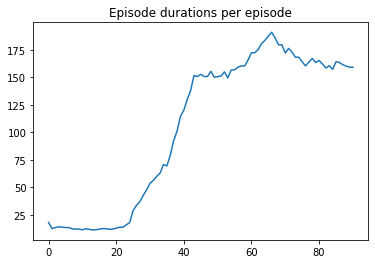

In [126]:
# And see the results
def smooth(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

plt.plot(smooth(episode_durations, 10))
plt.title('Episode durations per episode')


---

## 3. Policy Gradient (8 points)

So we have spent a lot of time working on *value based* methods. We will now switch to *policy based* methods, i.e. learn a policy directly rather than learn a value function from which the policy follows. Mention two advantages of using a policy based method.

YOUR ANSWER HERE

### 3.1 Policy Network

In order to do so, we will implement a Policy network. Although in general this does not have to be the case, we will use an architecture very similar to the Q-network (two layers with ReLU activation for the hidden layer). Since we have discrete actions, our model will output one value per action, where each value represents the (normalized!) log-probability of selecting that action. *Use the (log-)softmax activation function.*

In [ ]:
class PolicyNetwork(nn.Module):
    
    def __init__(self, num_hidden=128):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(4, num_hidden)
        self.l2 = nn.Linear(num_hidden, 2)

    def forward(self, x):
        # YOUR CODE HERE
        raise NotImplementedError()

In [ ]:
# Let's instantiate and test if it works
num_hidden = 128
torch.manual_seed(1234)
model = PolicyNetwork(num_hidden)

x = torch.rand(10, 4)

log_p = model(x)

# Does the outcome make sense?
print(log_p.exp())


### 3.2 Monte Carlo REINFORCE

Now we will implement the *Monte Carlo* policy gradient algorithm. Remember from lab 1 that this means that we will estimate returns for states by sample episodes. Compared to DQN, this means that we do *not* perform an update step at every environment step, but only at the end of each episode. This means that we should generate an episode of data, compute the REINFORCE loss (which requires computing the returns) and then perform a gradient step.

To help you, we already implemented a few functions that you can (but do not have to) use.

* You can use `torch.multinomial` to sample from a categorical distribution.
* The REINFORCE loss is defined as $- \sum_t \log \pi_\theta(a_t|s_t) G_t$, which means that you should compute the (discounted) return $G_t$ for all $t$. Make sure that you do this in **linear time**, otherwise your algorithm will be very slow! Note the - (minus) since you want to maximize return while you want to minimize the loss.
* Importantly, you should **normalize the returns** (not the rewards!, e.g. subtract mean and divide by standard deviation within the episode) before computing the loss, or your estimator will have very high variance.

In [ ]:
def select_action(model, state):
    # Samples an action according to the probability distribution induced by the model
    # Also returns the log_probability
    # YOUR CODE HERE
    raise NotImplementedError()
    
    return action, log_p[action]

def run_episode(env, model):
    # YOUR CODE HERE
    raise NotImplementedError()
    return episode

def compute_reinforce_loss(episode, discount_factor):
    # Compute the reinforce loss
    # Make sure that your function runs in LINEAR TIME
    # Don't forget to normalize your RETURNS (not rewards)
    # Note that the rewards/returns should be maximized 
    # while the loss should be minimized so you need a - somewhere
    
    # YOUR CODE HERE
    raise NotImplementedError()
    return loss

def run_episodes_policy_gradient(model, env, num_episodes, discount_factor, learn_rate):
    
    optimizer = optim.Adam(model.parameters(), learn_rate)
    
    episode_durations = []
    for i in range(num_episodes):
        
        # YOUR CODE HERE
        raise NotImplementedError()
                           
        if i % 10 == 0:
            print("{2} Episode {0} finished after {1} steps"
                  .format(i, len(episode), '\033[92m' if len(episode) >= 195 else '\033[99m'))
        episode_durations.append(len(episode))
        
    return episode_durations

In [ ]:
# Feel free to play around with the parameters!
num_episodes = 200
discount_factor = 0.99
learn_rate = 0.01
seed = 42
random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)

model = PolicyNetwork(num_hidden)

episode_durations_policy_gradient = run_episodes_policy_gradient(
    model, env, num_episodes, discount_factor, learn_rate)

plt.plot(smooth(episode_durations_policy_gradient, 10))
plt.title('Episode durations per episode')
plt.legend(['Policy gradient'])

## 4. Deep Reinforcement Learning (5 bonus points)
Note that so far we used the state variables as input. However, the true power of Deep Learning is that we can directly learn from raw inputs, e.g. we can learn to balance the cart pole *by just looking at the screen*. This probably means that you need a deep(er) (convolutional) network, as well as tweaking some parameters, running for more iterations (perhaps on GPU) and do other tricks to stabilize learning. Can you get this to work? This will earn you bonus points!

Hints:
* You may want to use [Google Colab](https://colab.research.google.com/) such that you can benefit from GPU acceleration.
* Even if you don't use Colab, save the weights of your final model and load it in the code here (see example below). Hand in the model file with the .ipynb in a .zip. We likely won't be able to run your training code during grading!
* Preprocessing is already done for you, and the observation is the difference between two consequtive frames such that the model can 'see' (angular) speed from a single image. Now do you see why we (sometimes) use the word observation (and not state)?

In [ ]:
import torchvision.transforms as T
from PIL import Image


resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])

class CartPoleRawEnv(gym.Env):
    
    def __init__(self, *args, **kwargs):
        self._env = gym.make('CartPole-v0', *args, **kwargs)  #.unwrapped
        self.action_space = self._env.action_space
        screen_height, screen_width = 40, 80  # TODO
        self.observation_space = gym.spaces.Box(
            low=0, high=255, 
            shape=(screen_height, screen_width, 3), dtype=np.uint8)
    
    def seed(self, seed=None):
        return self._env.seed(seed)
    
    def reset(self):
        s = self._env.reset()
        self.prev_screen = self.screen = self.get_screen()
        return self._get_observation()
    
    def step(self, action):
        s, r, done, info = self._env.step(action)
        self.prev_screen = self.screen
        self.screen = self.get_screen()
        return self._get_observation(), r, done, info
    
    def _get_observation(self):
        return self.screen - self.prev_screen
    
    def _get_cart_location(self, screen_width):
        _env = self._env.unwrapped
        world_width = _env.x_threshold * 2
        scale = screen_width / world_width
        return int(_env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

    def get_screen(self):
        screen = self._env.unwrapped.render(mode='rgb_array').transpose(
            (2, 0, 1))  # transpose into torch order (CHW)
        # Strip off the top and bottom of the screen
        _, screen_height, screen_width = screen.shape
        screen = screen[:, screen_height * 4 // 10:screen_height * 8 // 10]
        view_width = screen_height * 8 // 10
        cart_location = self._get_cart_location(screen_width)
        if cart_location < view_width // 2:
            slice_range = slice(view_width)
        elif cart_location > (screen_width - view_width // 2):
            slice_range = slice(-view_width, None)
        else:
            slice_range = slice(cart_location - view_width // 2,
                                cart_location + view_width // 2)
        # Strip off the edges, so that we have a square image centered on a cart
        screen = screen[:, :, slice_range]
        # Convert to float, rescare, convert to torch tensor
        # (this doesn't require a copy)
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)
        # Resize, and add a batch dimension (BCHW)
        #return screen.unsqueeze(0).to(device)
        return resize(screen).unsqueeze(0)
    
    def close(self):
        return self._env.close()

raw_env = CartPoleRawEnv()
s = raw_env.reset()

# 
s, r, done, _ = raw_env.step(env.action_space.sample())

raw_env.reset()
plt.figure()
plt.imshow(raw_env.get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

# Observations are (-1, 1) while we need to plot (0, 1) so show (rgb + 1) / 2
plt.figure()
plt.imshow((s.cpu().squeeze(0).permute(1, 2, 0).numpy() + 1) / 2,
           interpolation='none')
plt.title('Example observation')
plt.show()
raw_env.close()

In [ ]:
# Maybe you should make it a bit deeper?
class DeepPolicy(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(40 * 80 * 3, 2)

    def forward(self, x):
        # Flatten
        return F.log_softmax(self.l1(x.view(x.size(0), -1)), -1)
    
policy = DeepPolicy()
filename = 'weights.pt'

if os.path.isfile(filename):
    print(f"Loading weights from {filename}")
    weights = torch.load(filename, map_location='cpu')
    
    policy.load_state_dict(weights['policy'])
    
else:
    # Train
    
    ### TODO some training here, maybe? Or run this on a different machine?
    torch.manual_seed(42)
    
    print(f"Saving weights to {filename}")
    torch.save({
        # You can add more here if you need, e.g. critic
        'policy': policy.state_dict()  # Always save weights rather than objects
    },
    filename)
    
def bonus_get_action(x):
    return policy(x).exp().multinomial(1)[:, 0]

In [ ]:
seed = 42
episode_durations = []
for i in range(20):  # Not too many since it may take forever to render
    test_env = CartPoleRawEnv()
    test_env.seed(seed + i)
    state = test_env.reset()
    done = False
    steps = 0
    while not done:
        steps += 1
        with torch.no_grad():
            action = bonus_get_action(state).item()
        state, reward, done, _ = test_env.step(action)
    episode_durations.append(steps)
    test_env.close()
    
plt.plot(episode_durations)
plt.title('Episode durations')
plt.show()
